# Dividiendo Entrenamiento y Testeo

En este punto los datos están depurados y son la fuente de la verdad sobre la que se trabajará. Temas como agregaciones de nuevos conjuntos de datos están fuera del alcance del proyecto. Los algoritmos se desempeñan mejor con ciertos formatos, y algunos definitivamente no son aceptados, como lo podría ser status, que es una cadena de caracteres. La escala de los datos también es de interés, de modo que se atenderá esta situación en este cuaderno.

Para evitar la data leakage, que consiste en la fuga de información desde el conjunto de datos de Testo hacia el de Entrenamiento, de modo que existe una influencia que compromete el objetivo de resolver el problema y no solo de obtener métricas favorables. Se advierte en la literatura sobre esta fuga de información, y que es preferible dividir primero el conjunto de datos y luego aplicar las transformaciones que involucran el uso de un estadístico, como la normalización.

In [1]:
#Importando librearias
import sys
import urllib
import hashlib
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../../')
from Resources.mlTracker import *
from Python.Style.styles import  *
from Python.Preprocessing.funcs import  *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction import FeatureHasher
from imblearn.over_sampling import RandomOverSampler

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.float_format',  '{:,.8f}'.format)

In [3]:
#Utilizando diseño base 1
plt.style.use('../../Python/Style/style1.mplstyle')

In [4]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

In [5]:
#Seteando experimento de mlflow
mlflow.set_experiment("FE-Models")

<Experiment: artifact_location='file:///Users/victor.borrayo/Desktop/Tesis/trabajoGrad/Training/mlruns/641872054686892476', creation_time=1709862657620, experiment_id='641872054686892476', last_update_time=1709862657620, lifecycle_stage='active', name='FE-Models', tags={}>

In [ ]:
#Leyendo datos
equipos = pd.read_parquet("../../Data/DataMart/Views/DataViews/equipos_completo.parquet")
#gateways = pd.read_parquet("../../Data/DataMart/Views/DataViews/gateways_completo.parquet")
equipos.head()

## Dividiendo datos

In [6]:
#Eliminando columnas no requeridas
equipos.drop(['status','first_jump','NoCommunicatingDays','DaysSinceLastStatusChanged'],inplace=True,axis=1)

In [7]:
#Conviertiendo round
equipos['round'] = equipos['round'].str.extract('(\d+)').astype(int)

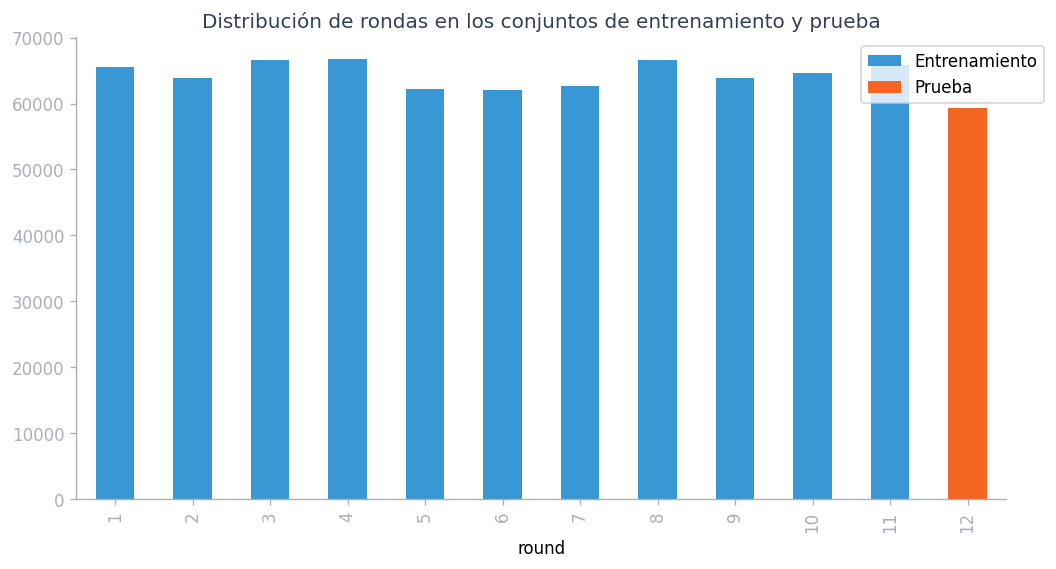

In [8]:
#Prueba
t_equipos = equipos.copy()
t_equipos['Conjunto'] = 'Entrenamiento'
t_equipos.loc[t_equipos['round'] > 11, 'Conjunto'] = 'Prueba'
t_equipos.sort_values('round', inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
# Gráfico de barras
t_equipos.groupby(['round', 'Conjunto']).size().unstack().plot(kind='bar', stacked=True, ax=ax, color=[mClr, sClr1])
plt.title('Distribución de rondas en los conjuntos de entrenamiento y prueba')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')



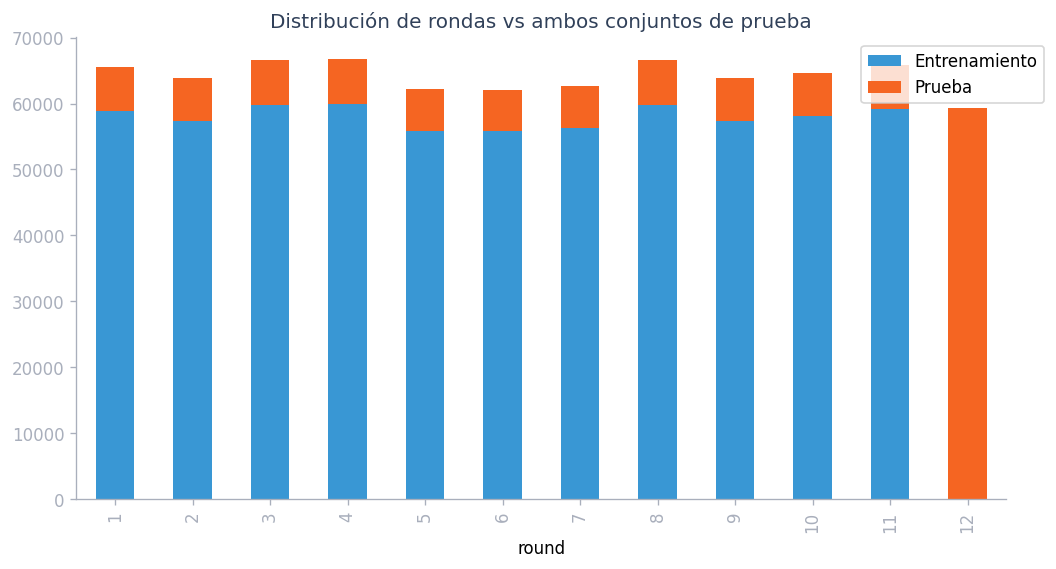

In [9]:
#División de datos basada en equipos
total_equipos = equipos['serialNumber'].unique()
#Seleccionando muestra del 20% de equipos
choosen_equipos = np.random.choice(total_equipos, int(len(total_equipos)*0.1), replace=False)
#Agregando etiqueta
t_equipos.loc[t_equipos['serialNumber'].isin(choosen_equipos), 'Conjunto'] = ['Prueba']*len(t_equipos[t_equipos['serialNumber'].isin(choosen_equipos)])
#Visualizando gráfica de barras
fig, ax = plt.subplots(figsize=(10, 5))
t_equipos.groupby(['round', 'Conjunto']).size().unstack().plot(kind='bar', stacked=True, ax=ax, color=[mClr, sClr1])
plt.title('Distribución de rondas vs ambos conjuntos de prueba')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')

Porcentaje de datos para prueba: 17.12


(array([0, 1]), [Text(0, 0, 'Entrenamiento'), Text(1, 0, 'Prueba')])

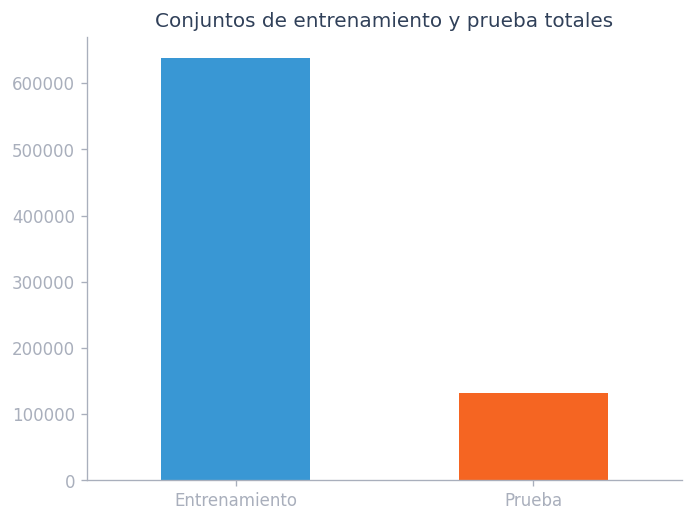

In [10]:
#Porcentaje de datos para prueba
print(f'Porcentaje de datos para prueba:',round((len(t_equipos[t_equipos['Conjunto'] == 'Prueba'])/len(t_equipos))*100,2))
#Visualizando proporción de entrenamiento y prueba
t_equipos['Conjunto'].value_counts().plot(kind='bar', color=[mClr, sClr1])
plt.title("Conjuntos de entrenamiento y prueba totales")
plt.xticks(rotation=0)

In [11]:
#Etiquetando sets de prueba
t_equipos['PSNumber'] = 'Entrenamiento'
t_equipos.loc[t_equipos['Conjunto'] == 'Prueba', 'PSNumber'] = 'Prueba Ronda'
t_equipos.loc[t_equipos.serialNumber.isin(choosen_equipos), 'PSNumber'] = 'Prueba Equipos'


Text(0.5, 1.0, 'Distribución de conjuntos de prueba')

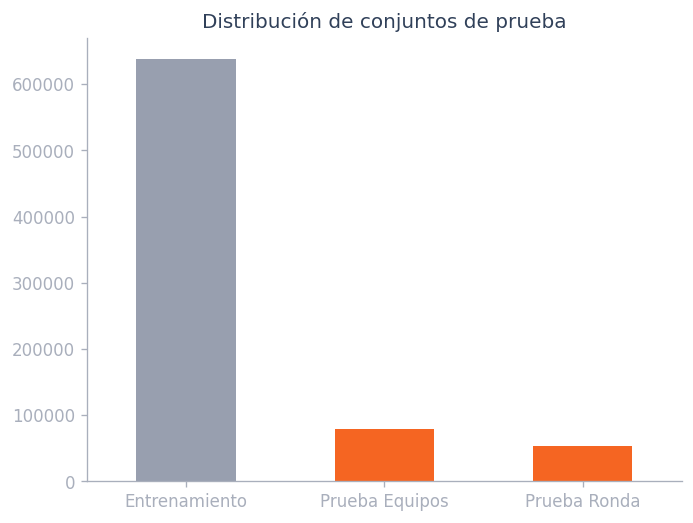

In [12]:
#Visualizando conjuntos de prueba
t_equipos.groupby('PSNumber').size().plot(kind='bar', color=[sClr2, sClr1, sClr1])
plt.xticks(rotation=0)
plt.xlabel(None)
plt.title('Distribución de conjuntos de prueba')

In [13]:
#t_equipos.to_parquet("../../Data/DataMart/Views/DataViews/equipos_splitted.parquet")

## Transformación de características

Se ha mencionado antes el problema del data leakage, para evitarlo, fue necesario realizar primero la división de los datos y luego obtener los "convertidores" del conjunto de datos. Los conjuntos de datos de prueba se transformarán conforme el conjunto de entrenamiento y no según sus propios estadísticos.


In [6]:
t_equipos = pd.read_parquet("../../Data/DataMart/Views/DataViews/equipos_splitted.parquet")

In [ ]:
#Codificando números de serie
t_equipos['serialNumber'] = t_equipos['serialNumber'].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
t_equipos['serialNumber_neighbor'] = t_equipos['serialNumber_neighbor'].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
def hash_list(x):
    return [hashlib.md5(str(i).encode()).hexdigest() for i in x]
t_equipos['fixed_path'] = t_equipos['fixed_path'].apply(hash_list)
t_equipos.head()

In [8]:
#Separando en dfs individuales
training = t_equipos[t_equipos['Conjunto'] == 'Entrenamiento']
testing1 = t_equipos[t_equipos['PSNumber'] == 'Prueba Ronda']
testing2 = t_equipos[t_equipos['PSNumber'] == 'Prueba Equipos']
#Reset indexes
training.reset_index(drop=True, inplace=True)
testing1.reset_index(drop=True, inplace=True)
testing2.reset_index(drop=True, inplace=True)

### Codificación binaria

In [9]:
#Convirtiendo números a columnas de bits
def ordinary_to_bits(col):
    col = np.array(col)
    max_values = np.max(col)
    number_of_bits = int(np.ceil(np.log2(max_values + 1)))
    
    def int_to_bits(x):
        return list(map(int, list(bin(int(x))[2:].zfill(number_of_bits))))
    
    binary_array = np.array([int_to_bits(x) for x in col])
    return binary_array

In [ ]:
#Codificación binaria
ordinal_gw = OrdinalEncoder()

ordinal_gw = ordinal_gw.fit(np.array(training['CollectorNm']).reshape(-1,1))

training['CollectorNm'] = ordinal_gw.transform(np.array(training['CollectorNm']).reshape(-1,1))
training['CollectorNm_neighbor'] = ordinal_gw.transform(np.array(training['CollectorNm_neighbor']).reshape(-1,1))
testing1['CollectorNm'] = ordinal_gw.transform(np.array(testing1['CollectorNm']).reshape(-1,1))
testing1['CollectorNm_neighbor'] = ordinal_gw.transform(np.array(testing1['CollectorNm_neighbor']).reshape(-1,1))
testing2['CollectorNm'] = ordinal_gw.transform(np.array(testing2['CollectorNm']).reshape(-1,1))
testing2['CollectorNm_neighbor'] = ordinal_gw.transform(np.array(testing2['CollectorNm_neighbor']).reshape(-1,1))


#Convirtiendo a binario
max_bit = int(np.ceil(np.log2(np.max(training['CollectorNm']) + 1)))
col_names_1 = [f'CollectorNm_{i}' for i in range(max_bit)]
col_names_2 = [f'CollectorNm_neighbor_{i}' for i in range(max_bit)]
#Aplicando función
training[col_names_1] = pd.DataFrame(ordinary_to_bits(training['CollectorNm']), columns=col_names_1)
training[col_names_2] = pd.DataFrame(ordinary_to_bits(training['CollectorNm_neighbor']), columns=col_names_2)
testing1[col_names_1] = pd.DataFrame(ordinary_to_bits(testing1['CollectorNm']), columns=col_names_1)
testing1[col_names_2] = pd.DataFrame(ordinary_to_bits(testing1['CollectorNm_neighbor']), columns=col_names_2)
testing2[col_names_1] = pd.DataFrame(ordinary_to_bits(testing2['CollectorNm']), columns=col_names_1)
testing2[col_names_2] = pd.DataFrame(ordinary_to_bits(testing2['CollectorNm_neighbor']), columns=col_names_2)
#Eliminando columnas originales
training.drop(['CollectorNm', 'CollectorNm_neighbor'], axis=1, inplace=True)
testing1.drop(['CollectorNm', 'CollectorNm_neighbor'], axis=1, inplace=True)
testing2.drop(['CollectorNm', 'CollectorNm_neighbor'], axis=1, inplace=True)
#Mostrando df
training.head()

In [12]:
#Almacenando encoder
with mlflow.start_run(run_name = "binaryEncoding"):
    mlflow.sklearn.log_model(ordinal_gw, "OrdinalEncoder")
    mlflow.end_run()

2024/05/07 13:23:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [11]:
#Checkeando for nans
print('Nans en training:',training.isna().sum().sum())
print('Nans en testing1:',testing1.isna().sum().sum())
print('Nans en testing2:',testing2.isna().sum().sum())

Nans en training: 0
Nans en testing1: 0
Nans en testing2: 0


### One Hot Encoding

In [ ]:
#Preparando Antena
training['Antena'] = training['Antena'].astype(str)
testing1['Antena'] = testing1['Antena'].astype(str)
testing2['Antena'] = testing2['Antena'].astype(str)
#One hot encoding
ohe_status_neigh = OneHotEncoder()
ohe_type = OneHotEncoder()
ohe_type_neighbor = OneHotEncoder()
ohe_cluster = OneHotEncoder()
ohe_cluster_neighbor = OneHotEncoder()
ohe_cluster_gw = OneHotEncoder()
ohe_antena = OneHotEncoder()
#Ajustando
ohe_status = ohe_status_neigh.fit(np.array(training['status_neighbor']).reshape(-1,1))
ohe_type = ohe_type.fit(np.array(training['type']).reshape(-1,1))
ohe_type_neighbor = ohe_type_neighbor.fit(np.array(training['type_neighbor']).reshape(-1,1))
ohe_cluster = ohe_cluster.fit(np.array(training['cluster']).reshape(-1,1))
ohe_cluster_neighbor = ohe_cluster.fit(np.array(training['cluster_neighbor']).reshape(-1,1))
ohe_cluster_gw = ohe_cluster.fit(np.array(training['cluster_gw']).reshape(-1,1))
ohe_antena = ohe_antena.fit(np.array(training['Antena']).reshape(-1,1))
#Transformando
#Training
status_neighbor_ohe = ohe_status.transform(np.array(training['status_neighbor']).reshape(-1,1)).toarray()
type = ohe_type.transform(np.array(training['type']).reshape(-1,1)).toarray()
type_neighbor = ohe_type_neighbor.transform(np.array(training['type_neighbor']).reshape(-1,1)).toarray()
cluster = ohe_cluster.transform(np.array(training['cluster']).reshape(-1,1)).toarray()
cluster_neighbor = ohe_cluster.transform(np.array(training['cluster_neighbor']).reshape(-1,1)).toarray()
cluster_gw = ohe_cluster.transform(np.array(training['cluster_gw']).reshape(-1,1)).toarray()
antena = ohe_antena.transform(np.array(training['Antena']).reshape(-1,1)).toarray()
#Testing1
t1_status_neighbor_ohe = ohe_status.transform(np.array(testing1['status_neighbor']).reshape(-1,1)).toarray()
t1_type = ohe_type.transform(np.array(testing1['type']).reshape(-1,1)).toarray()
t1_type_neighbor = ohe_type_neighbor.transform(np.array(testing1['type_neighbor']).reshape(-1,1)).toarray()
t1_cluster = ohe_cluster.transform(np.array(testing1['cluster']).reshape(-1,1)).toarray()
t1_cluster_neighbor = ohe_cluster.transform(np.array(testing1['cluster_neighbor']).reshape(-1,1)).toarray()
t1_cluster_gw = ohe_cluster.transform(np.array(testing1['cluster_gw']).reshape(-1,1)).toarray()
t1_antena = ohe_antena.transform(np.array(testing1['Antena']).reshape(-1,1)).toarray()
#Testing2
t2_status_neighbor_ohe = ohe_status.transform(np.array(testing2['status_neighbor']).reshape(-1,1)).toarray()
t2_type = ohe_type.transform(np.array(testing2['type']).reshape(-1,1)).toarray()
t2_type_neighbor = ohe_type_neighbor.transform(np.array(testing2['type_neighbor']).reshape(-1,1)).toarray()
t2_cluster = ohe_cluster.transform(np.array(testing2['cluster']).reshape(-1,1)).toarray()
t2_cluster_neighbor = ohe_cluster.transform(np.array(testing2['cluster_neighbor']).reshape(-1,1)).toarray()
t2_cluster_gw = ohe_cluster.transform(np.array(testing2['cluster_gw']).reshape(-1,1)).toarray()
t2_antena = ohe_antena.transform(np.array(testing2['Antena']).reshape(-1,1)).toarray()

#Columnas
status_neighbor_columns = [f'status_neighbor_{i}' for i in range(status_neighbor_ohe.shape[1])]
type_columns = [f'type_{i}' for i in range(type.shape[1])]
type_neighbor_columns = [f'type_neighbor_{i}' for i in range(type_neighbor.shape[1])]
cluster_columns = [f'cluster_{i}' for i in range(cluster.shape[1])]
cluster_neighbor_columns = [f'cluster_neighbor_{i}' for i in range(cluster_neighbor.shape[1])]
cluster_gw_columns = [f'cluster_gw_{i}' for i in range(cluster_gw.shape[1])]
antena_columns = [f'antena_{i}' for i in range(antena.shape[1])]

#Asignando a dfs
#Training
training[status_neighbor_columns] = pd.DataFrame(status_neighbor_ohe, columns=status_neighbor_columns)
training[type_columns] = pd.DataFrame(type, columns=type_columns)
training[type_neighbor_columns] = pd.DataFrame(type_neighbor, columns=type_neighbor_columns)
training[cluster_columns] = pd.DataFrame(cluster, columns=cluster_columns)
training[cluster_neighbor_columns] = pd.DataFrame(cluster_neighbor, columns=cluster_neighbor_columns)
training[cluster_gw_columns] = pd.DataFrame(cluster_gw, columns=cluster_gw_columns)
training[antena_columns] = pd.DataFrame(antena, columns=antena_columns)
#Testing1
testing1[status_neighbor_columns] = pd.DataFrame(t1_status_neighbor_ohe, columns=status_neighbor_columns)
testing1[type_columns] = pd.DataFrame(t1_type, columns=type_columns)
testing1[type_neighbor_columns] = pd.DataFrame(t1_type_neighbor, columns=type_neighbor_columns)
testing1[cluster_columns] = pd.DataFrame(t1_cluster, columns=cluster_columns)
testing1[cluster_neighbor_columns] = pd.DataFrame(t1_cluster_neighbor, columns=cluster_neighbor_columns)
testing1[cluster_gw_columns] = pd.DataFrame(t1_cluster_gw, columns=cluster_gw_columns)
testing1[antena_columns] = pd.DataFrame(t1_antena, columns=antena_columns)
#Testing2
testing2[status_neighbor_columns] = pd.DataFrame(t2_status_neighbor_ohe, columns=status_neighbor_columns)
testing2[type_columns] = pd.DataFrame(t2_type, columns=type_columns)
testing2[type_neighbor_columns] = pd.DataFrame(t2_type_neighbor, columns=type_neighbor_columns)
testing2[cluster_columns] = pd.DataFrame(t2_cluster, columns=cluster_columns)
testing2[cluster_neighbor_columns] = pd.DataFrame(t2_cluster_neighbor, columns=cluster_neighbor_columns)
testing2[cluster_gw_columns] = pd.DataFrame(t2_cluster_gw, columns=cluster_gw_columns)
testing2[antena_columns] = pd.DataFrame(t2_antena, columns=antena_columns)
#Eliminando columnas originales
training.drop(['status_neighbor', 'type', 'type_neighbor', 'cluster','cluster_neighbor','cluster_gw'], axis=1, inplace=True)
testing1.drop(['status_neighbor', 'type', 'type_neighbor', 'cluster','cluster_neighbor','cluster_gw'], axis=1, inplace=True)
testing2.drop(['status_neighbor', 'type', 'type_neighbor', 'cluster','cluster_neighbor','cluster_gw'], axis=1, inplace=True)
#
training.head()

In [14]:
#Almacenando OHEs
with mlflow.start_run(run_name = "OneHotEncoding"):
    mlflow.sklearn.log_model(ohe_status_neigh, "OHE_status_neighbor")
    mlflow.sklearn.log_model(ohe_type, "OHE_type")
    mlflow.sklearn.log_model(ohe_type_neighbor, "OHE_type_neighbor")
    mlflow.sklearn.log_model(ohe_cluster, "OHE_cluster")
    mlflow.sklearn.log_model(ohe_cluster, "OHE_cluster_neighbor")
    mlflow.sklearn.log_model(ohe_cluster, "OHE_cluster_gw")
    mlflow.sklearn.log_model(ohe_antena, "OHE_antena")
    mlflow.end_run()

2024/04/28 17:55:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 17:55:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 17:55:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 17:55:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 17:55:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 17:55:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 17:55:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [13]:
#Checkeando for nans
print('Nans en training:',training.isna().sum().sum())
print('Nans en testing1:',testing1.isna().sum().sum())
print('Nans en testing2:',testing2.isna().sum().sum())

Nans en training: 0
Nans en testing1: 0
Nans en testing2: 0


### Escalando campos numéricos

In [14]:
#Identificando campos sin variabilidad en datos numéricos
numeric_cols = ['latitude','longitude','round','numberOfNeighbors','layer','path_length','h','R_mean','R_variance','R_skewness','G_mean',\
            'G_variance','G_skewness','B_mean','B_variance','B_skewness','latitude_neighbor','longitude_neighbor','NoCommunicatingDays_neighbor',\
            'numberOfNeighbors_neighbor','layer_neighbor','DaysSinceLastStatusChanged_neighbor','path_length_neighbor','h_neighbor','R_mean_neighbor',\
            'R_variance_neighbor','R_skewness_neighbor','G_mean_neighbor','G_variance_neighbor','G_skewness_neighbor','B_mean_neighbor','B_variance_neighbor',\
            'B_skewness_neighbor','latitude_gw','longitude_gw','numberOfNeighbors_gw','h_gw','R_mean_gw','R_variance_gw','R_skewness_gw','G_mean_gw',\
            'G_variance_gw','G_skewness_gw','B_mean_gw','B_variance_gw','B_skewness_gw','e1','e2','e3','e4','e5','e6','e7','e8','e9','e10','e11','e12',\
            'e13','e14','e15','e16','e17','e18','e19','e20','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17',\
            'f18','f19','f20']

variance_training = training[numeric_cols].var()
variance_testing1 = testing1[numeric_cols].var()
variance_testing2 = testing2[numeric_cols].var()
variance_training.head()


latitude              0.03957108
longitude             0.87087046
round                10.09421470
numberOfNeighbors   711.43891532
layer                 3.29280519
dtype: float64

In [15]:
#Determinando columnas sin variabilidad
tr_training = variance_training[variance_training == 0]
tr_testing1 = variance_testing1[variance_testing1 == 0]
tr_testing2 = variance_testing2[variance_testing2 == 0]
#Imprimiendo
print(f'Columnas sin variabilidad en training: {tr_training}')
print(f'Columnas sin variabilidad en testing1: {tr_testing1}')
print(f'Columnas sin variabilidad en testing2: {tr_testing2}')


Columnas sin variabilidad en training: f1   0.00000000
dtype: float64
Columnas sin variabilidad en testing1: round   0.00000000
f1      0.00000000
dtype: float64
Columnas sin variabilidad en testing2: f1   0.00000000
dtype: float64


In [16]:
#Numeric data
n_data = training[numeric_cols]

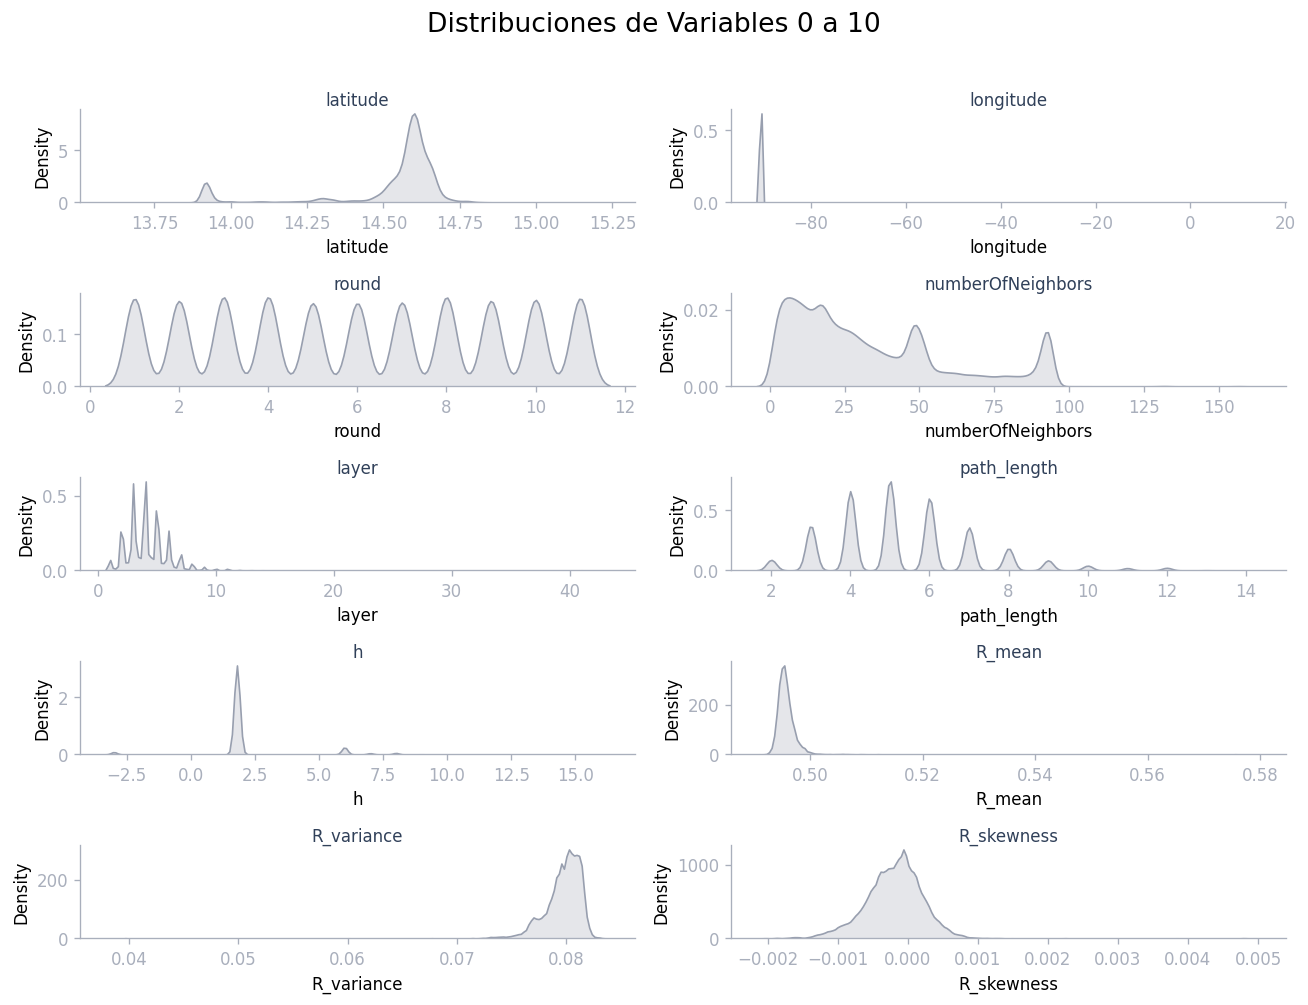

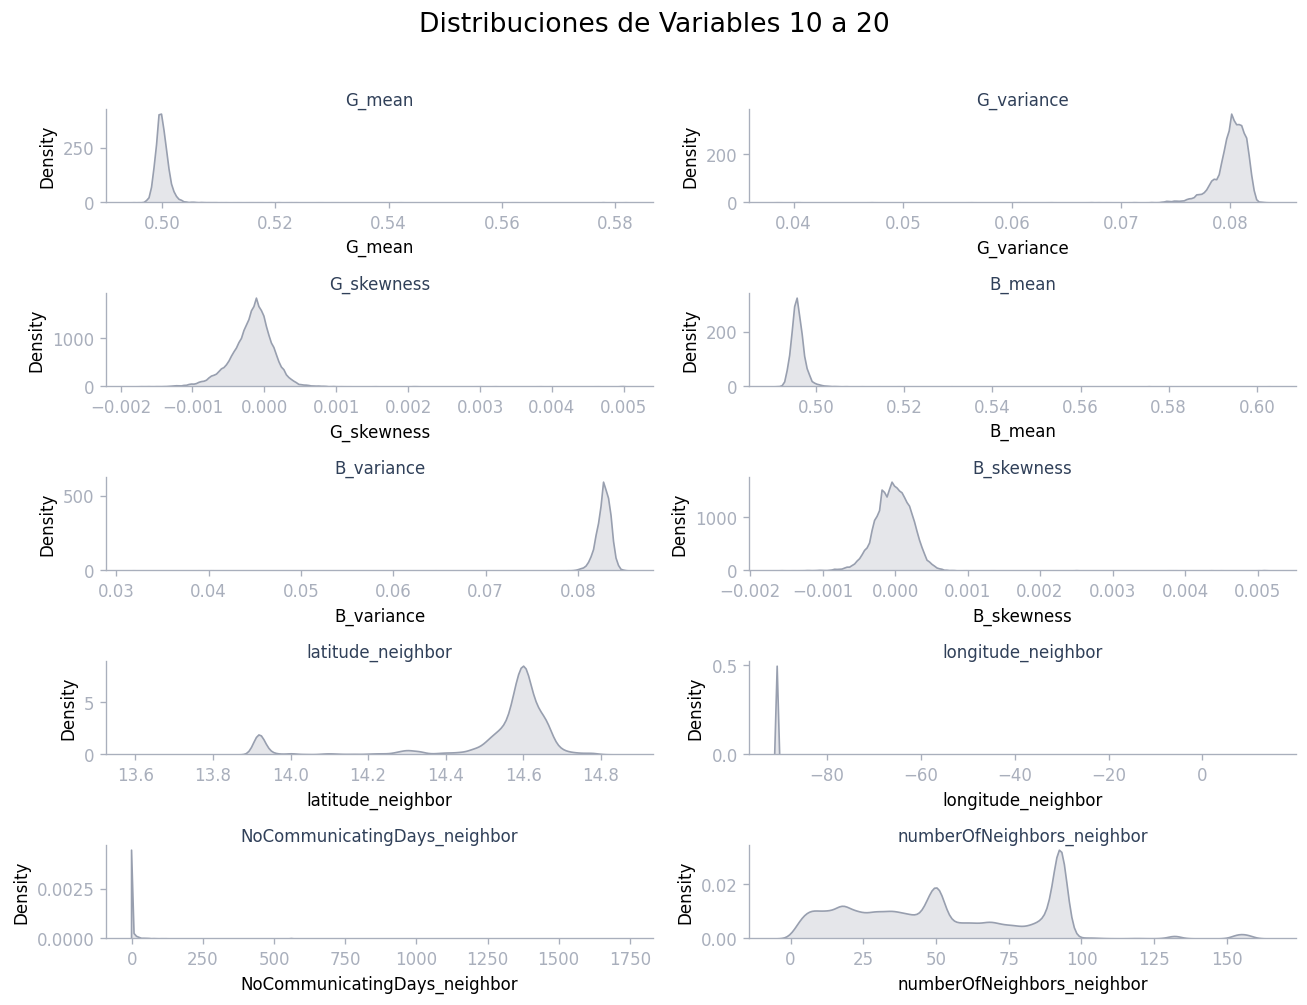

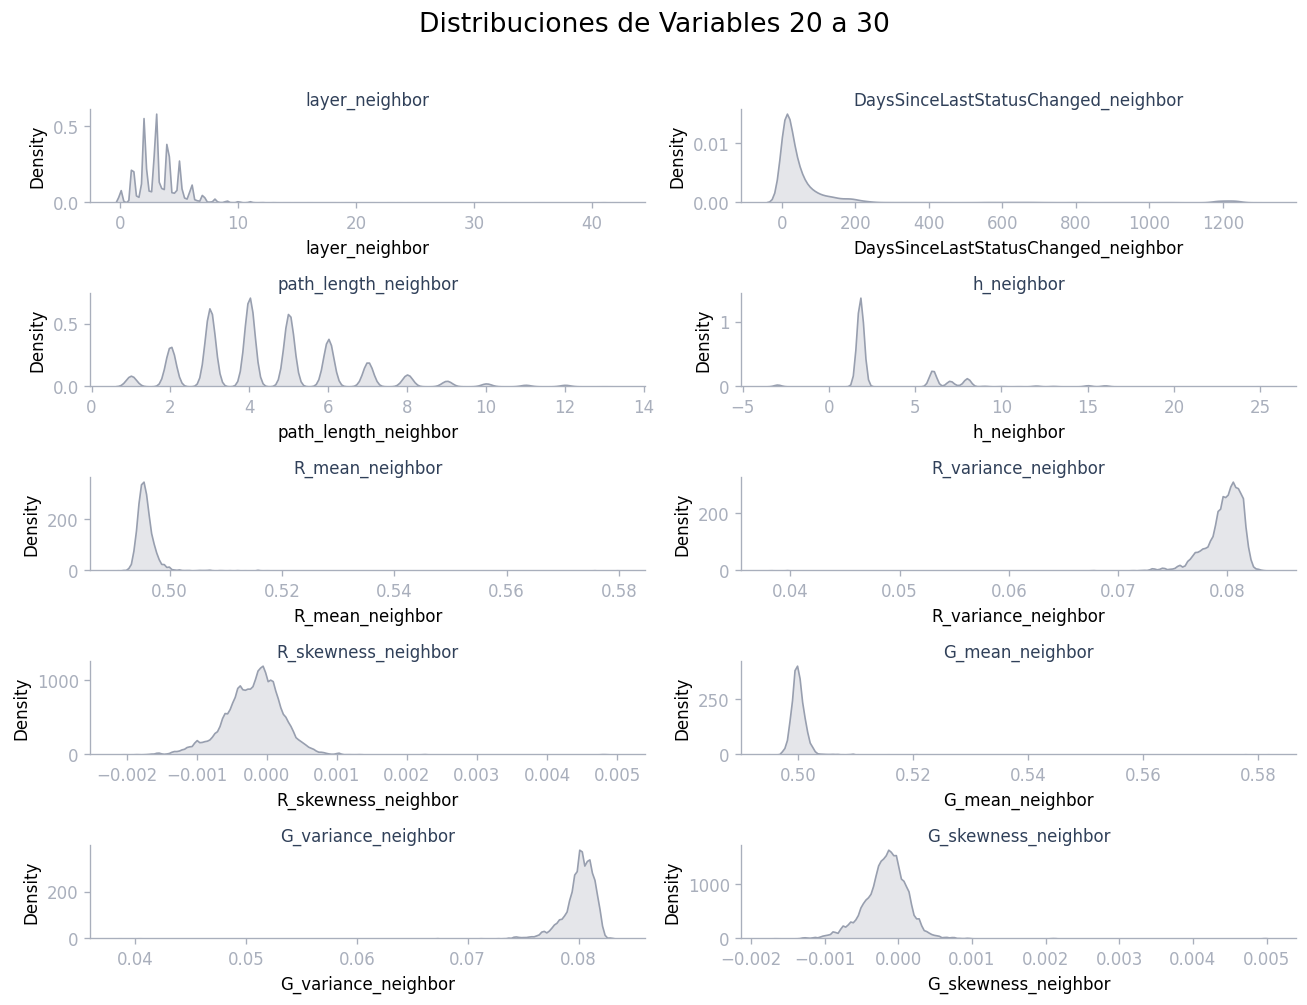

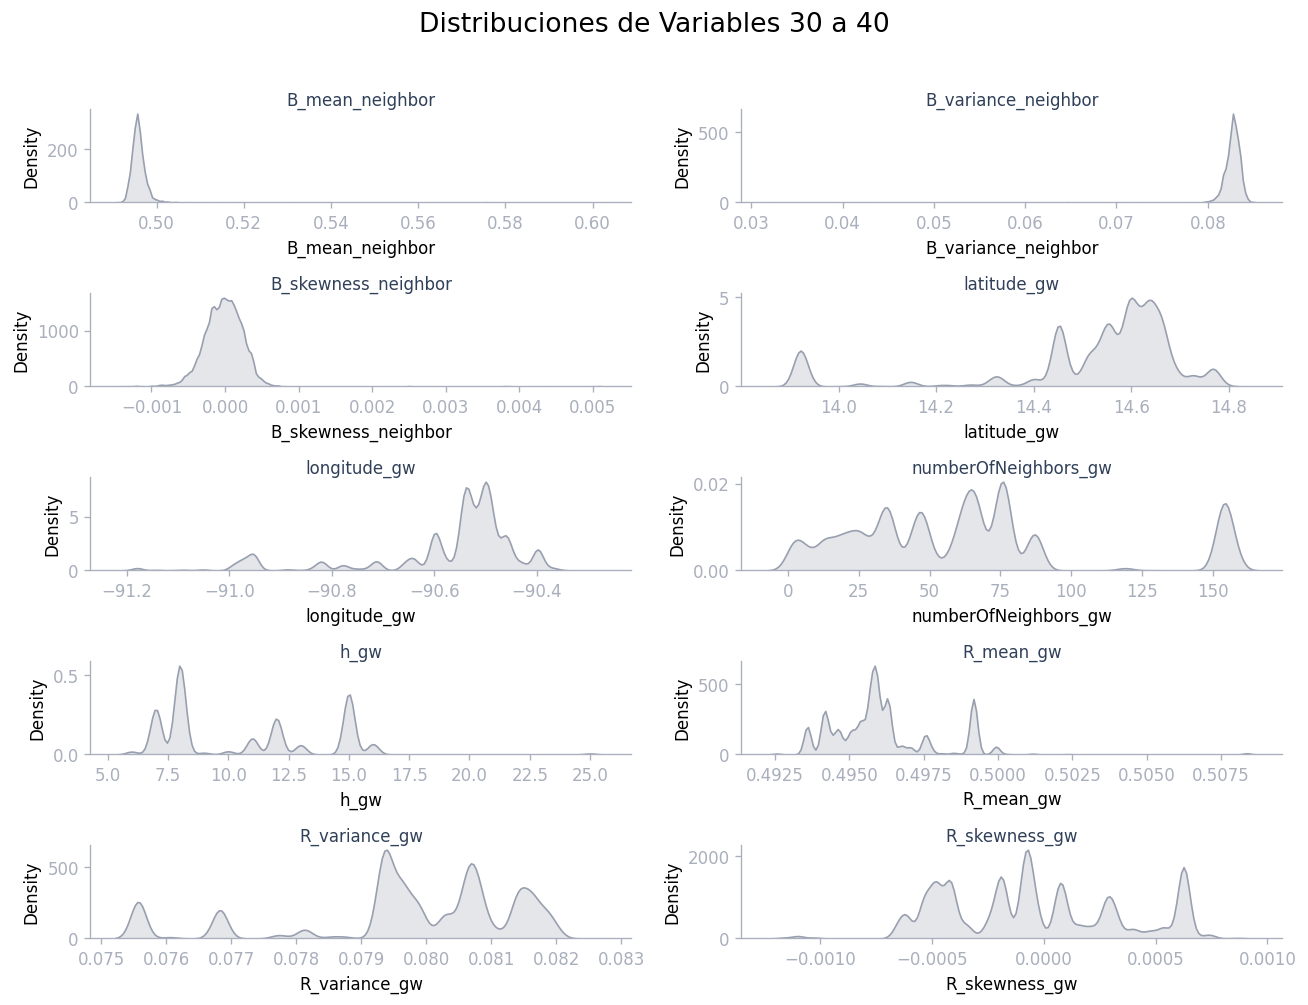

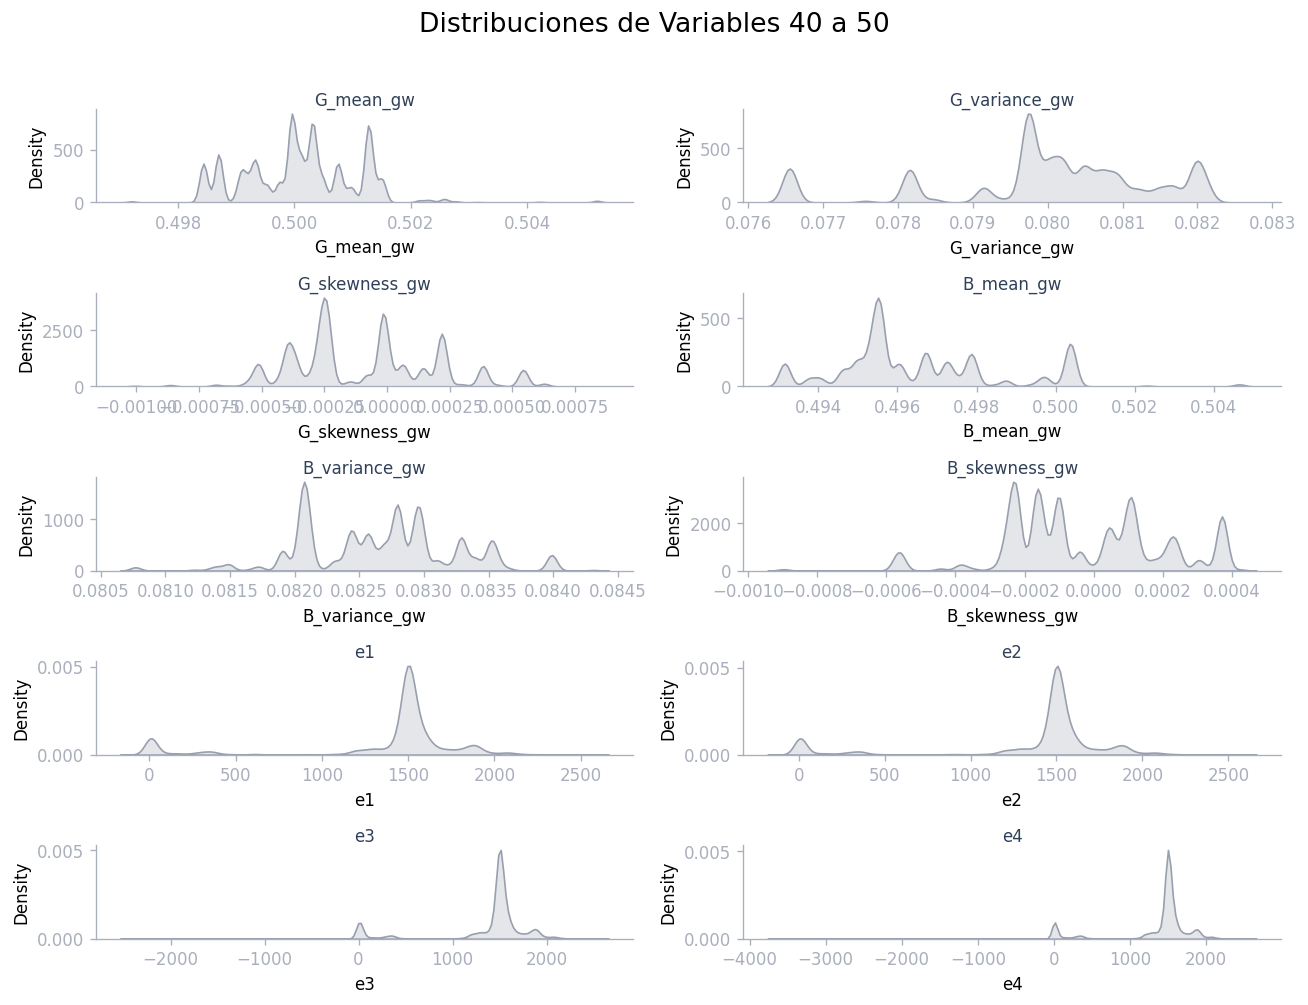

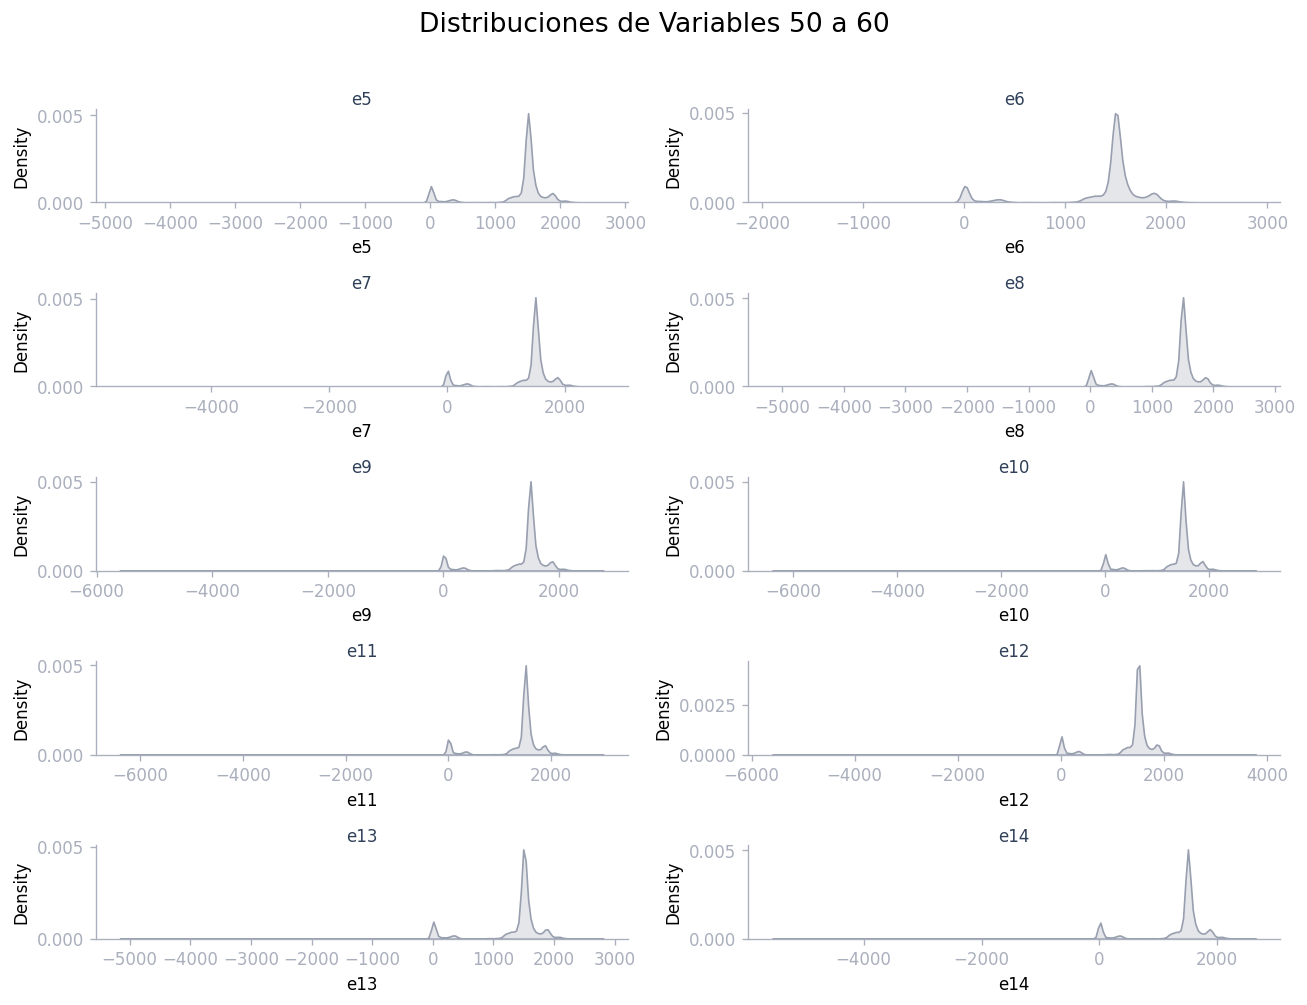

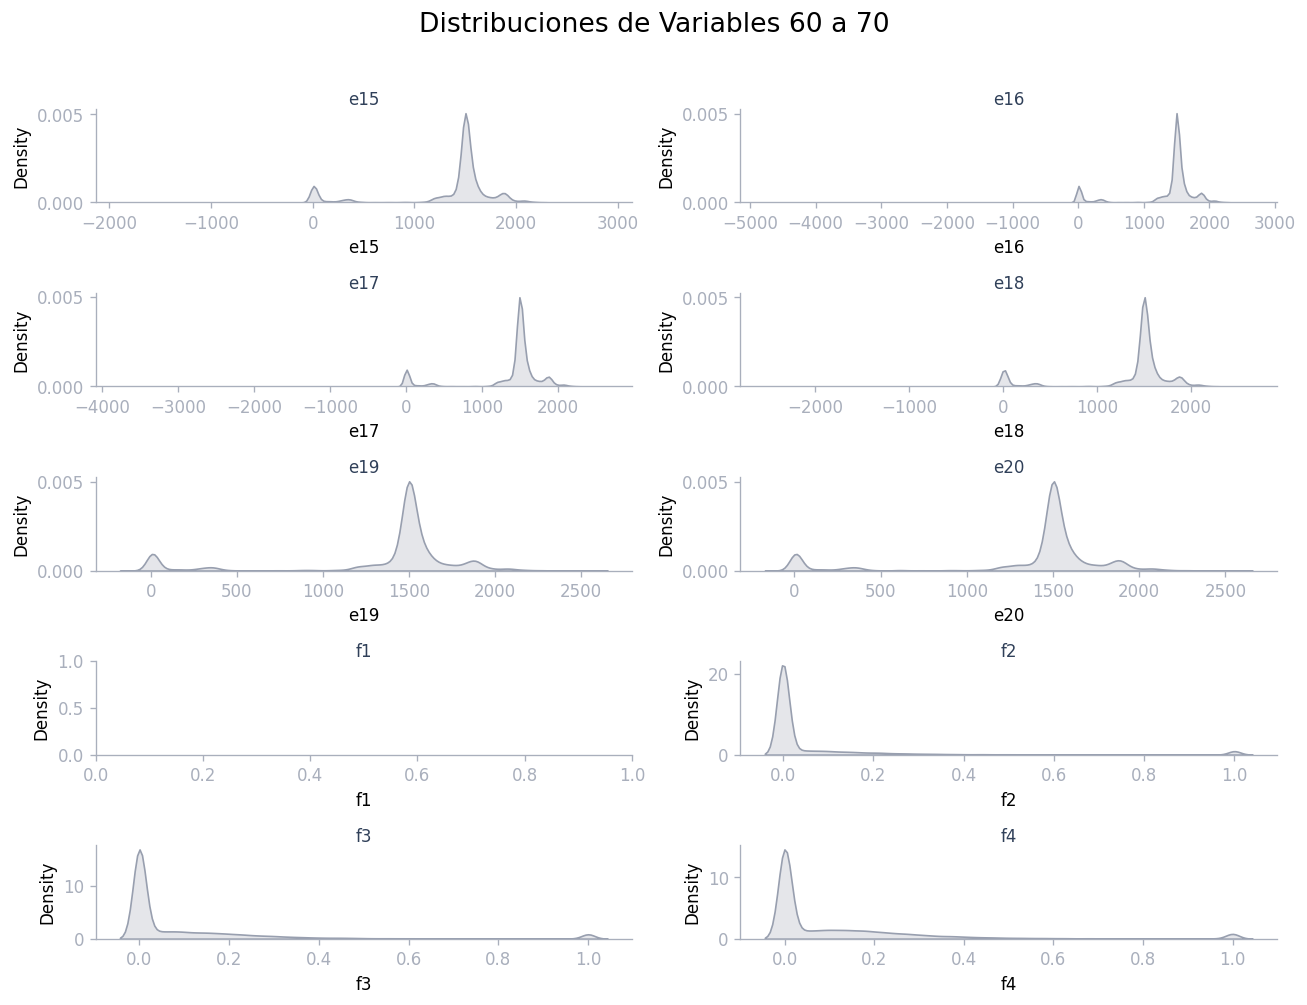

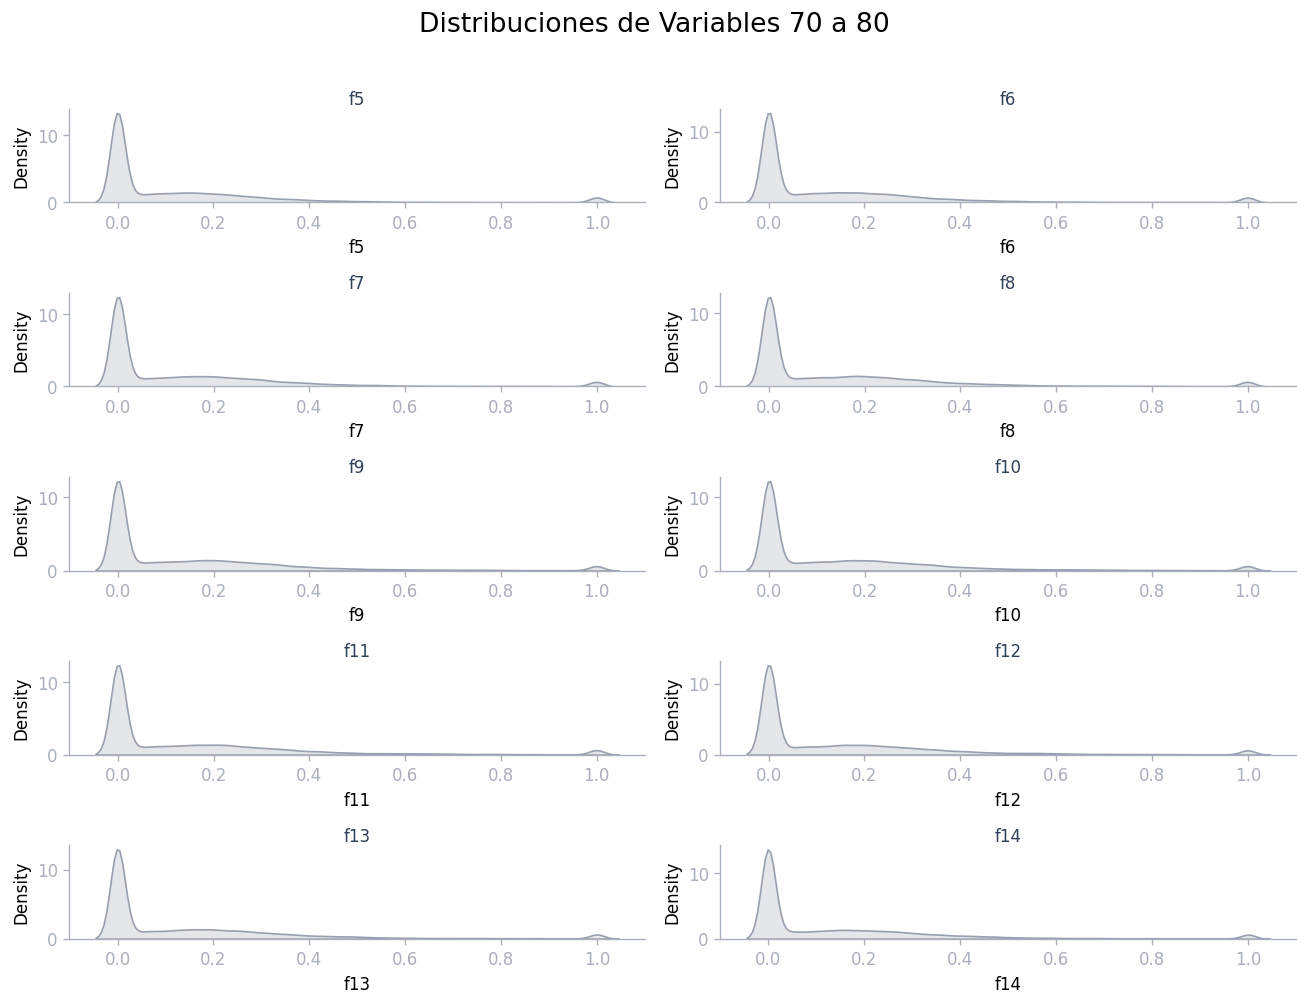

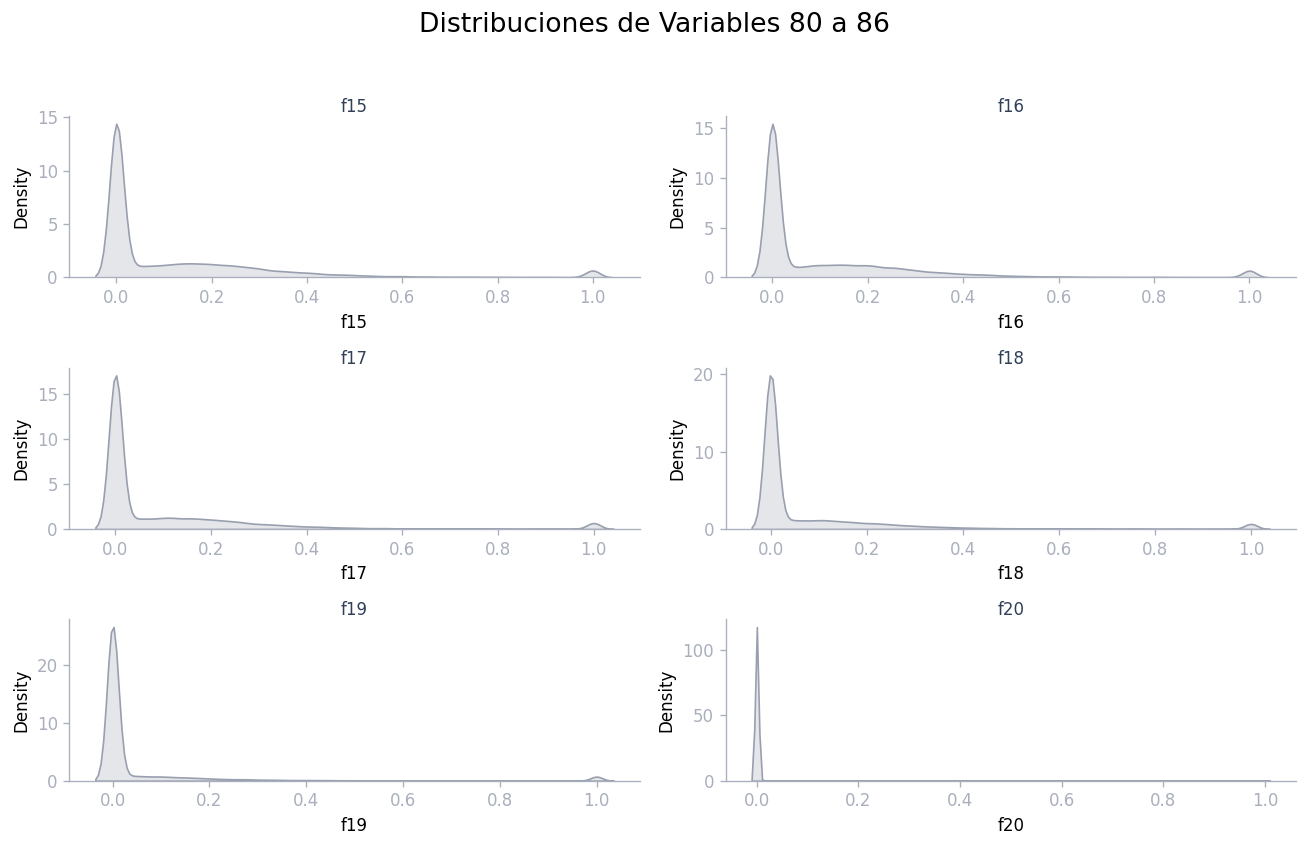

In [17]:
def plot_kde(data, start, end, fig_index, max_plots, color):
    num_plots = end - start
    diff = max_plots - num_plots
    if diff > 0:
        hr = [0.1] + [1]*int(np.ceil(num_plots/2))
        pending_rows = (1 + np.ceil(max_plots/2)) - len(hr)
        hr = hr + [0.1]*int(pending_rows)
    else:
        hr = [0.1] + [1]*(np.ceil(max_plots/2).astype(int))
    fig, axes = plt.subplots(int(1 + (np.ceil(max_plots/2))), 2, figsize=(11, 8.5), gridspec_kw={'height_ratios': hr})
    axes[0, 0].set_visible(False)
    axes[0, 1].set_visible(False)
    for i in range(num_plots +2,max_plots+2):
        axes[i// 2, (i) % 2].set_visible(False)
    #Graficando
    for i in range(num_plots):
        ax = plt.subplot(6, 2, i + 3)
        sns.kdeplot(data[data.columns[start + i]], fill=True, color = color)
        plt.title(data.columns[start + i], fontsize=10, pad=2)
        plt.tight_layout()

    fig.suptitle(f'Distribuciones de Variables {start} a {end}', fontsize=16, va='top')    
    plt.savefig(f'../../Python/PythonGImages/FE-Graphs/kde_plots_{fig_index}.png')
    plt.show()

#Realizando gráficos
num_variables = n_data.shape[1]
plots_per_page = 10
pages = (num_variables // plots_per_page) + (1 if num_variables % plots_per_page else 0)

for page in range(pages):
    start_index = page * plots_per_page
    end_index = min(start_index + plots_per_page, num_variables)
    plot_kde(n_data, start_index, end_index, page + 1, plots_per_page,sClr2)

In [18]:
#Eliminando variables con poca o nula variabilidad
#Eliminando f1
training.drop('f1', inplace=True, axis =1)
testing1.drop('f1', inplace=True, axis =1)
testing2.drop('f1', inplace=True, axis =1)
#Eliminando f20
training.drop('f20', inplace=True, axis =1)
testing1.drop('f20', inplace=True, axis =1)
testing2.drop('f20', inplace=True, axis =1)

#### Eliminando longitudes erróneas a training

In [19]:
#Tratando longitud
sn_issue = training[training['longitude']>0]['serialNumber'].unique()
#Conteo de ocurrencias
training[training['serialNumber'].isin(sn_issue)]['serialNumber'].value_counts()

4fc3d8cb534a09936fdb57d2910dd0d7    35
3e00a45fdb8ca3657f1c42ec27e4a3b6    14
Name: serialNumber, dtype: int64

In [ ]:
set_issues = set(sn_issue)
badNeighbor = training[training['fixed_path'].apply(lambda x: bool(set_issues&set(x)))]
#Unique sn
print(f"Uniques:\n {badNeighbor['serialNumber'].unique()}")
badNeighbor.head()

In [ ]:
#Eliminando longitudes erróneas
print(f'Número de registros antes de eliminar: {len(training)}')
training = training[~training['fixed_path'].apply(lambda x: bool(set_issues&set(x)))]
print(f'Número de registros después de eliminar: {len(training)}')
training.head()

#### Eliminando longitudes erróneas a Testing1

In [22]:
sn_issue2 = testing1[testing1['longitude']>0]['serialNumber'].unique()
#Conteo de ocurrencias
testing1[testing1['serialNumber'].isin(sn_issue2)]['serialNumber'].value_counts()

3e00a45fdb8ca3657f1c42ec27e4a3b6    5
Name: serialNumber, dtype: int64

In [ ]:
set_issues2 = set(sn_issue2)
badNeighbor2 = testing1[testing1['fixed_path'].apply(lambda x: bool(set_issues2&set(x)))]
#Unique sn
print(f"Uniques:\n {badNeighbor2['serialNumber'].unique()}")
badNeighbor2.head()

In [ ]:
#Eliminando longitudes erróneas
print(f'Número de registros antes de eliminar: {len(testing1)}')
testing1 = testing1[~testing1['fixed_path'].apply(lambda x: bool(set_issues2&set(x)))]
print(f'Número de registros después de eliminar: {len(testing1)}')
testing1.head()

#### Eliminando longitudes erróneas de Testing2

In [25]:
sn_issue3 = testing2[testing2['longitude']>0]['serialNumber'].unique()
#Conteo de ocurrencias
testing2[testing2['serialNumber'].isin(sn_issue3)]['serialNumber'].value_counts()

Series([], Name: serialNumber, dtype: int64)

#### Aplicando escala

In [26]:
#Función de estandarización
def scale_features(train_data, test_data1, test_data2, feature_names):
    scalers = {}
    for feature in feature_names:
        scaler = MinMaxScaler()
        #Ajustando el scaler
        scaler.fit(train_data[[feature]])
        #Transformando
        train_data[feature] = scaler.transform(train_data[[feature]])
        test_data1[feature] = scaler.transform(test_data1[[feature]])
        test_data2[feature] = scaler.transform(test_data2[[feature]])
        #Almacenando scaler
        scalers[feature] = scaler
    return train_data, test_data1, test_data2, scalers

In [27]:
#Aplicando transformación
numeric_cols = list(filter(lambda x: x not in ['f1','f20'], numeric_cols))
training, testing1, testing2, scalers = scale_features(training, testing1, testing2, numeric_cols)
training.head()

,serialNumber,latitude,longitude,round,fixed_path,FE-Comments,ImgName,numberOfNeighbors,layer,Communicating,...,cluster_gw_4,cluster_gw_5,cluster_gw_6,cluster_gw_7,cluster_gw_8,cluster_gw_9,cluster_gw_10,antena_0,antena_1,antena_2
0,bfc96ca87201c057b846974b5eadacff,0.61181481,0.59755737,0.00000000,"[b77e657e2ba241ac242417ffc06362a1, 56de3244cc9...",[],satImg-989,0.05710660,0.07142857,1,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000
1,8be32a384906718e80c4521450f50da0,0.43288519,0.21319625,0.00000000,"[7392fcb91425506993db84d4088f2662, fc7031b688e...",[],satImg-321,0.00000000,0.09523810,1,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000
2,8be32a384906718e80c4521450f50da0,0.43288519,0.21319625,0.00000000,"[3a746d1c194f1dfebd565308de21464e, fc7031b688e...",[],satImg-321,0.00000000,0.09523810,1,...,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000
3,42e69435d2156106a0d826984431fd64,0.66496003,0.53356239,0.00000000,"[fc3ac975c3a24f7413ff8d6788bb920f, 247ac55a5f7...",[],satImg-9724,0.07614213,0.04761905,1,...,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000
4,842b952e7d67081ab890cd1117347b17,0.63093779,0.57428208,0.00000000,"[74c3493cf03d043cbbbc3de055ee6622, 55bd8ac03ce...",[],satImg-13075,0.10152284,0.04761905,1,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000


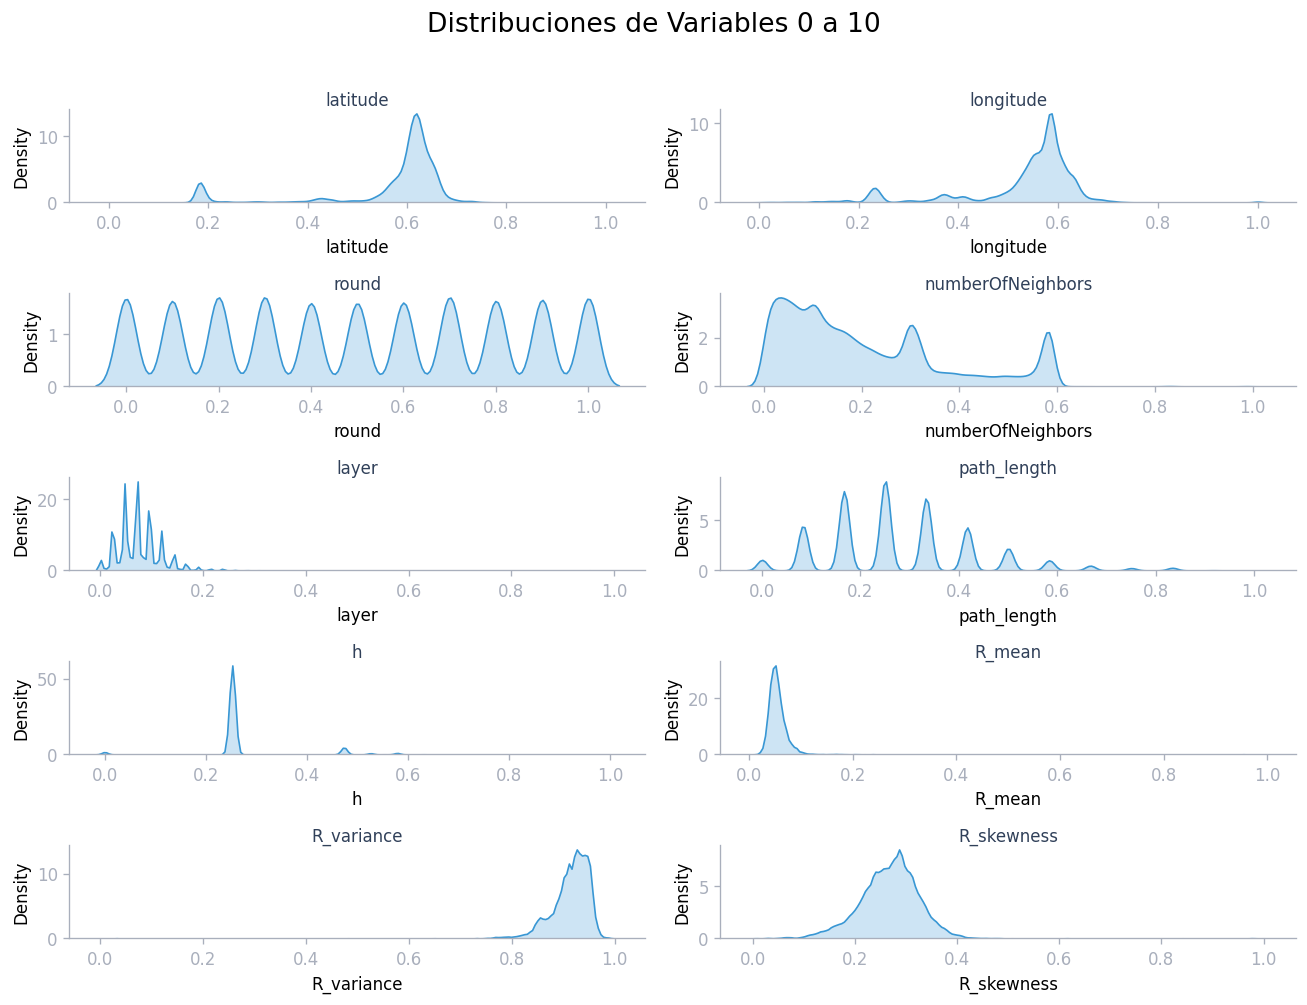

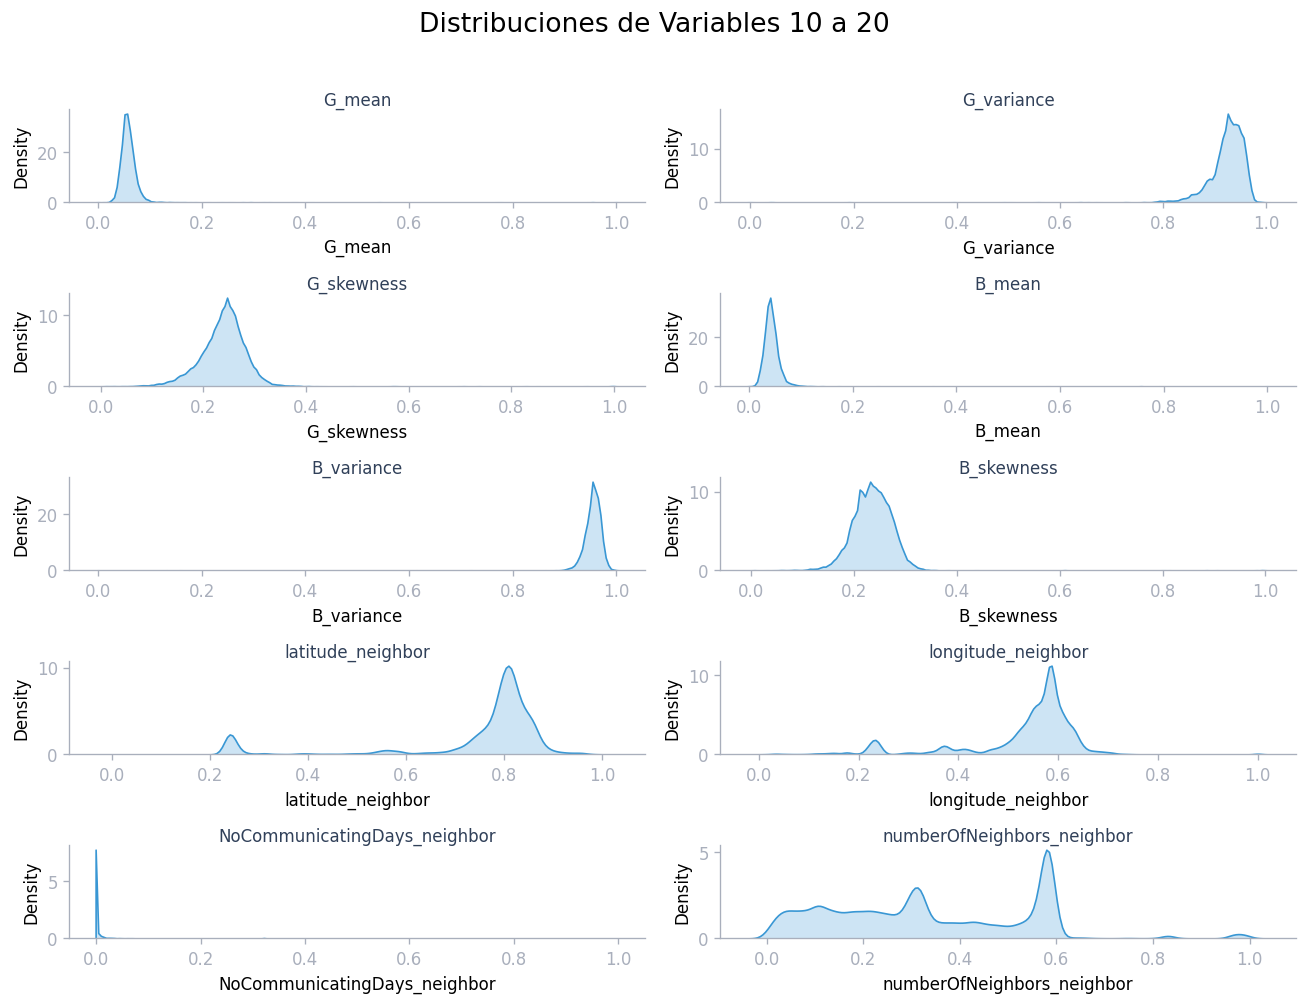

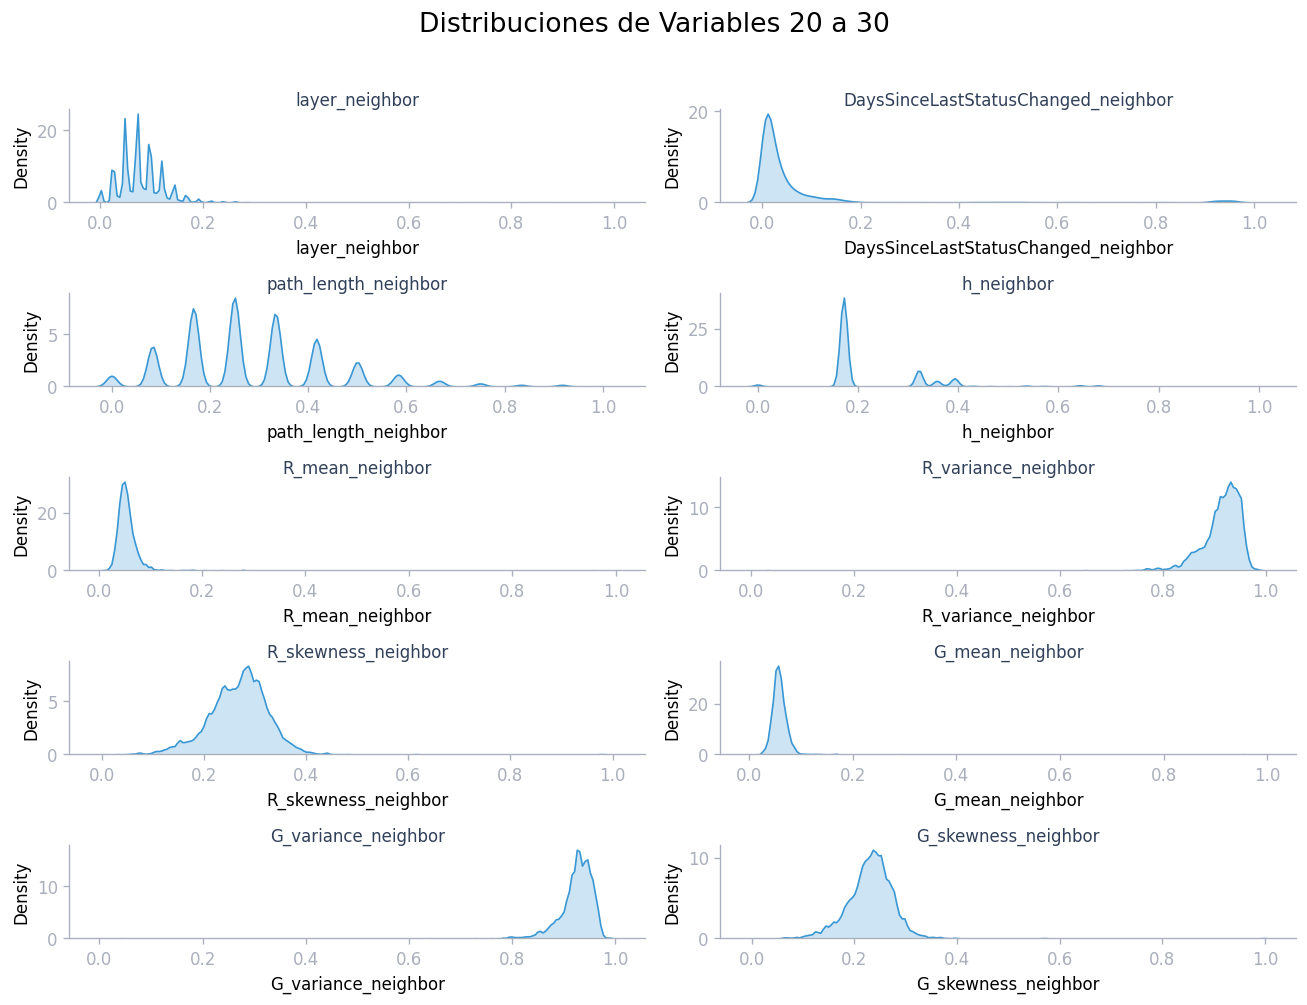

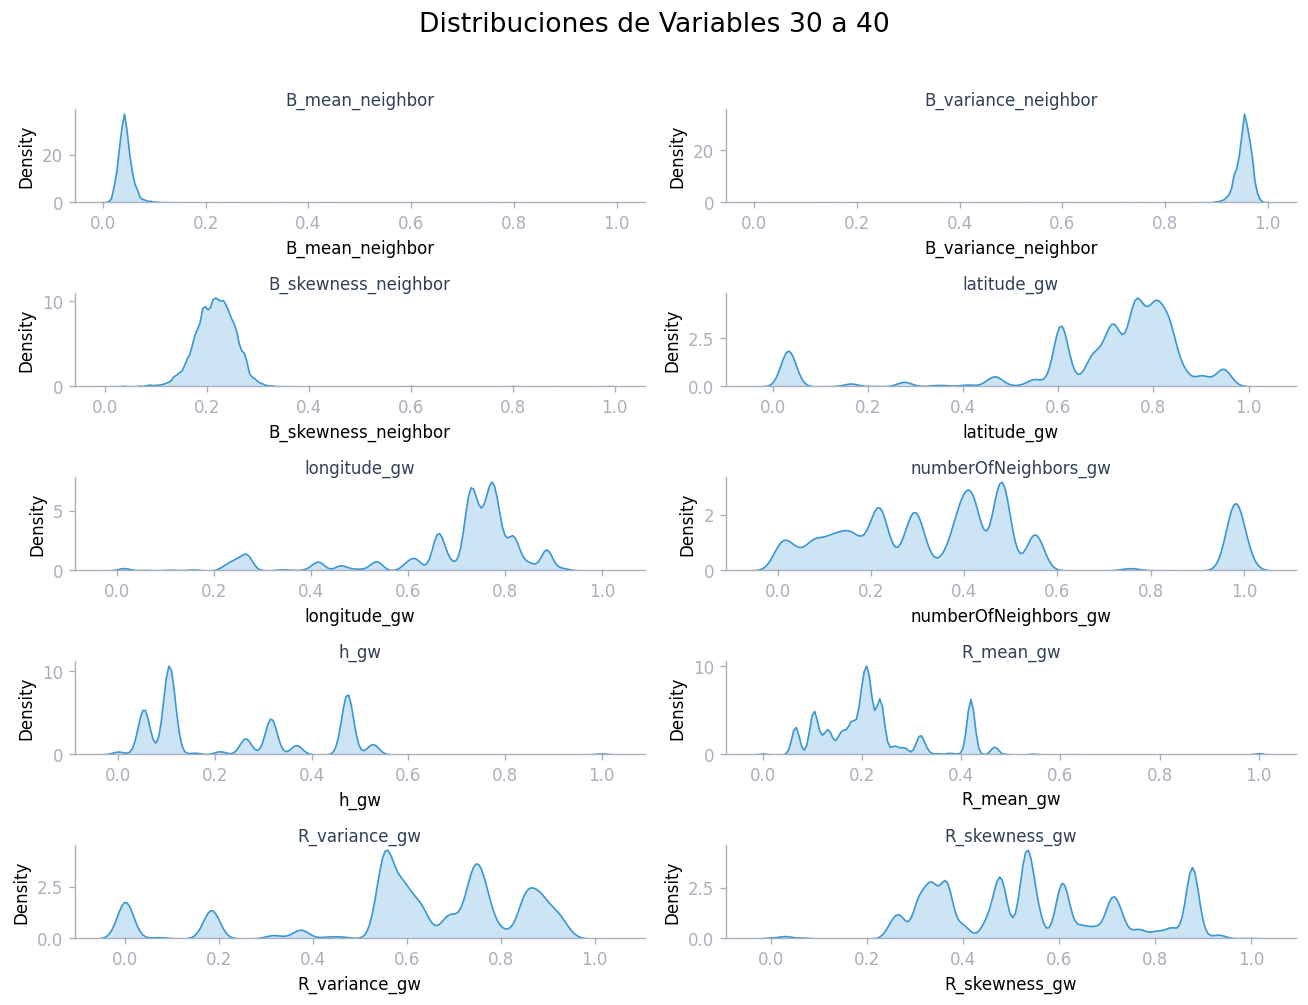

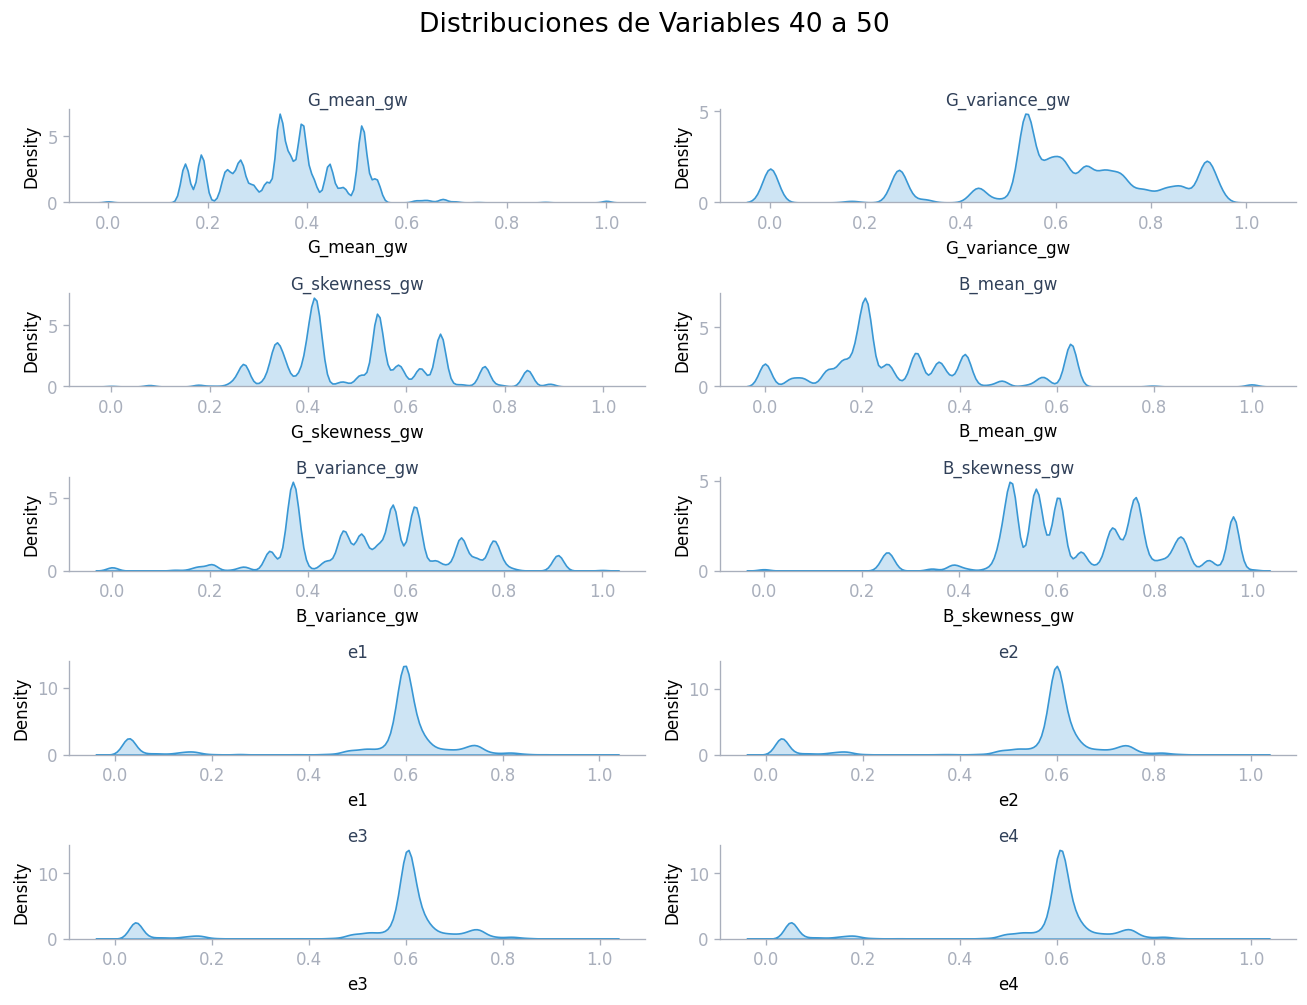

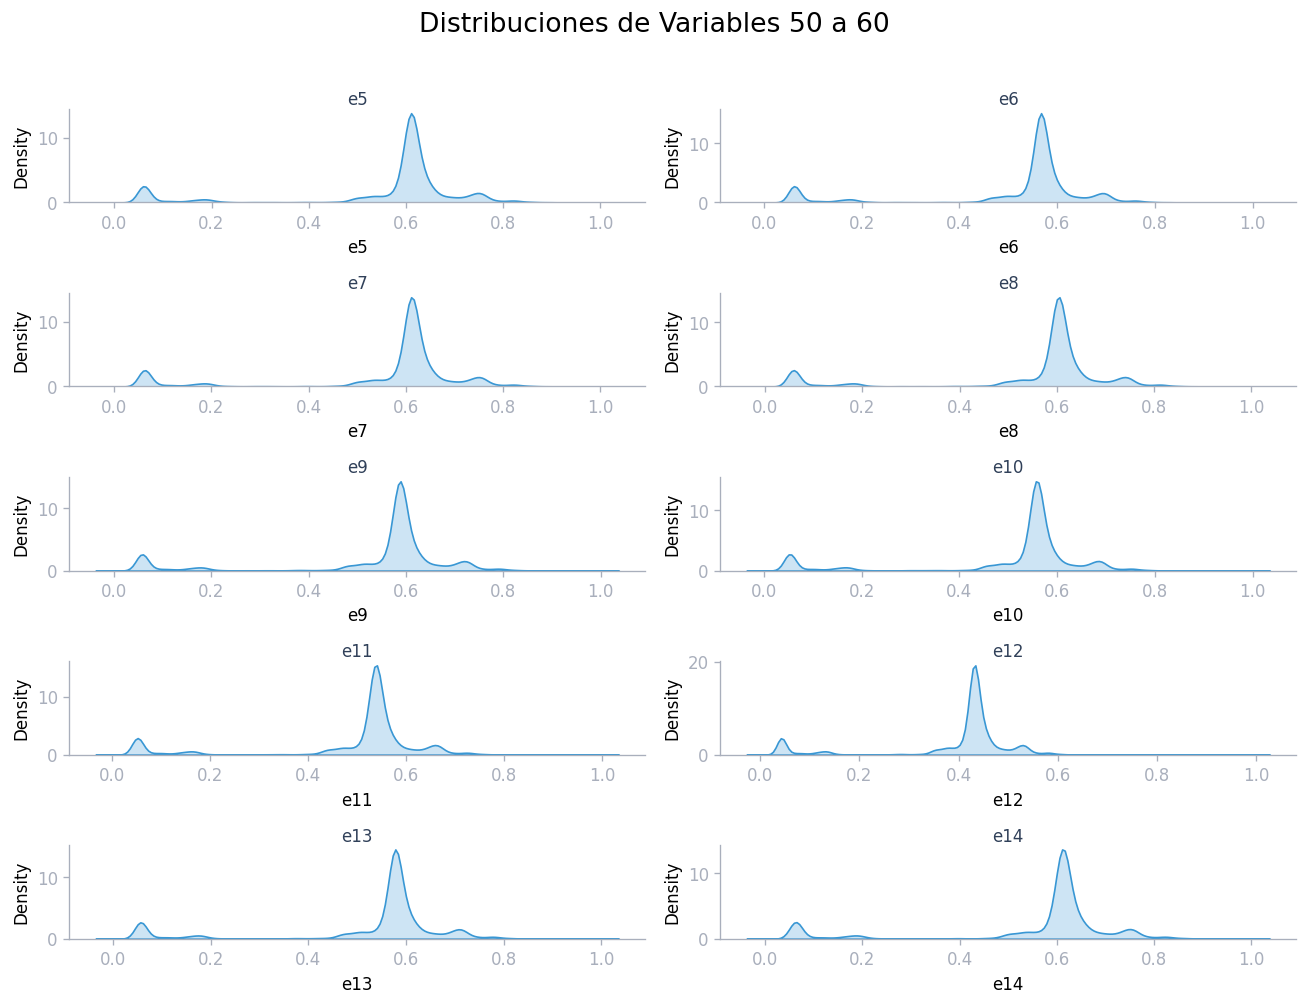

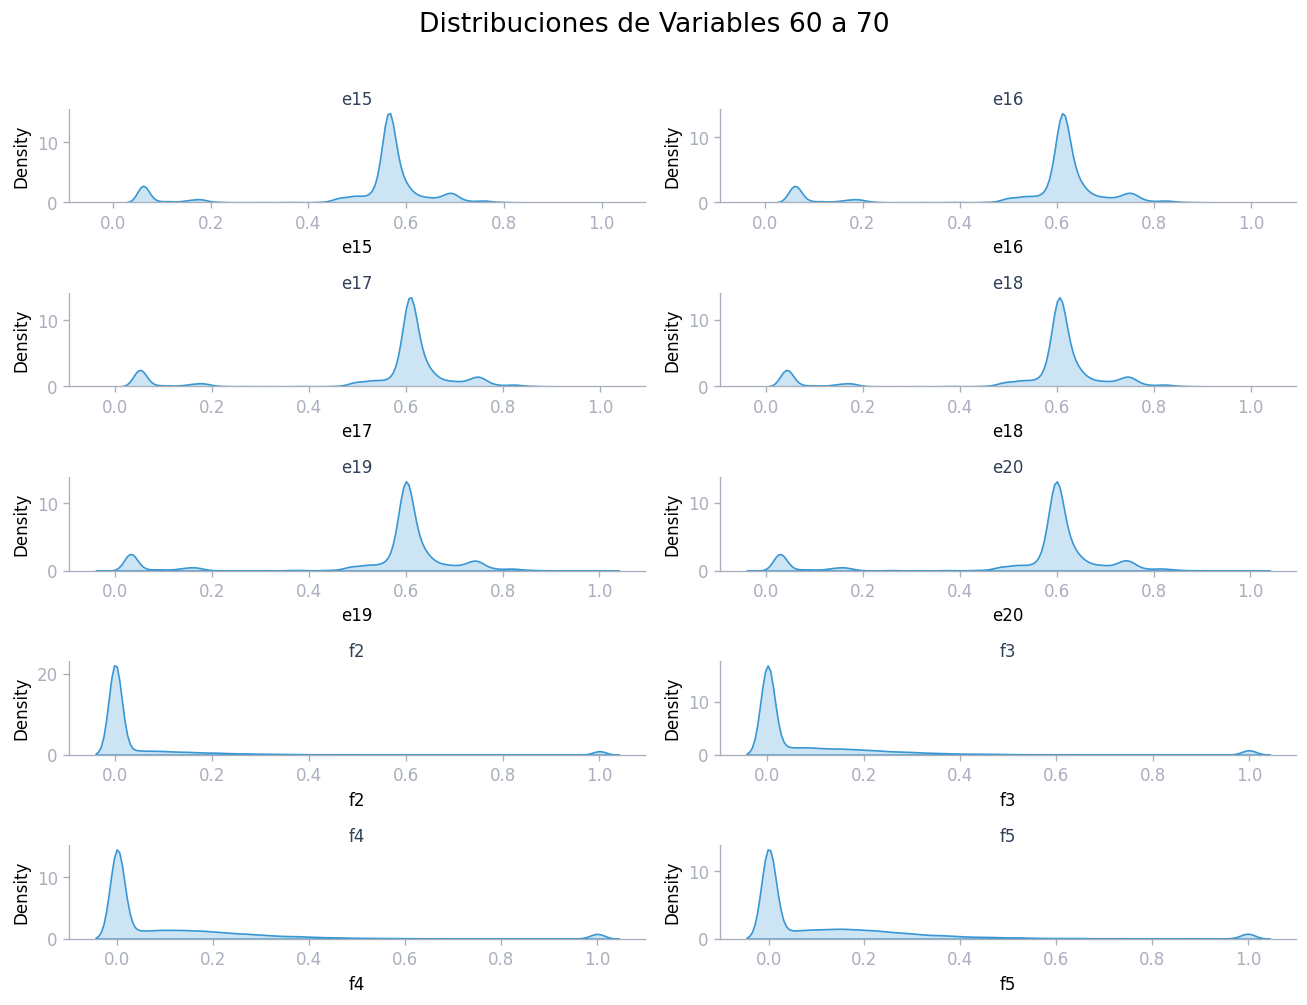

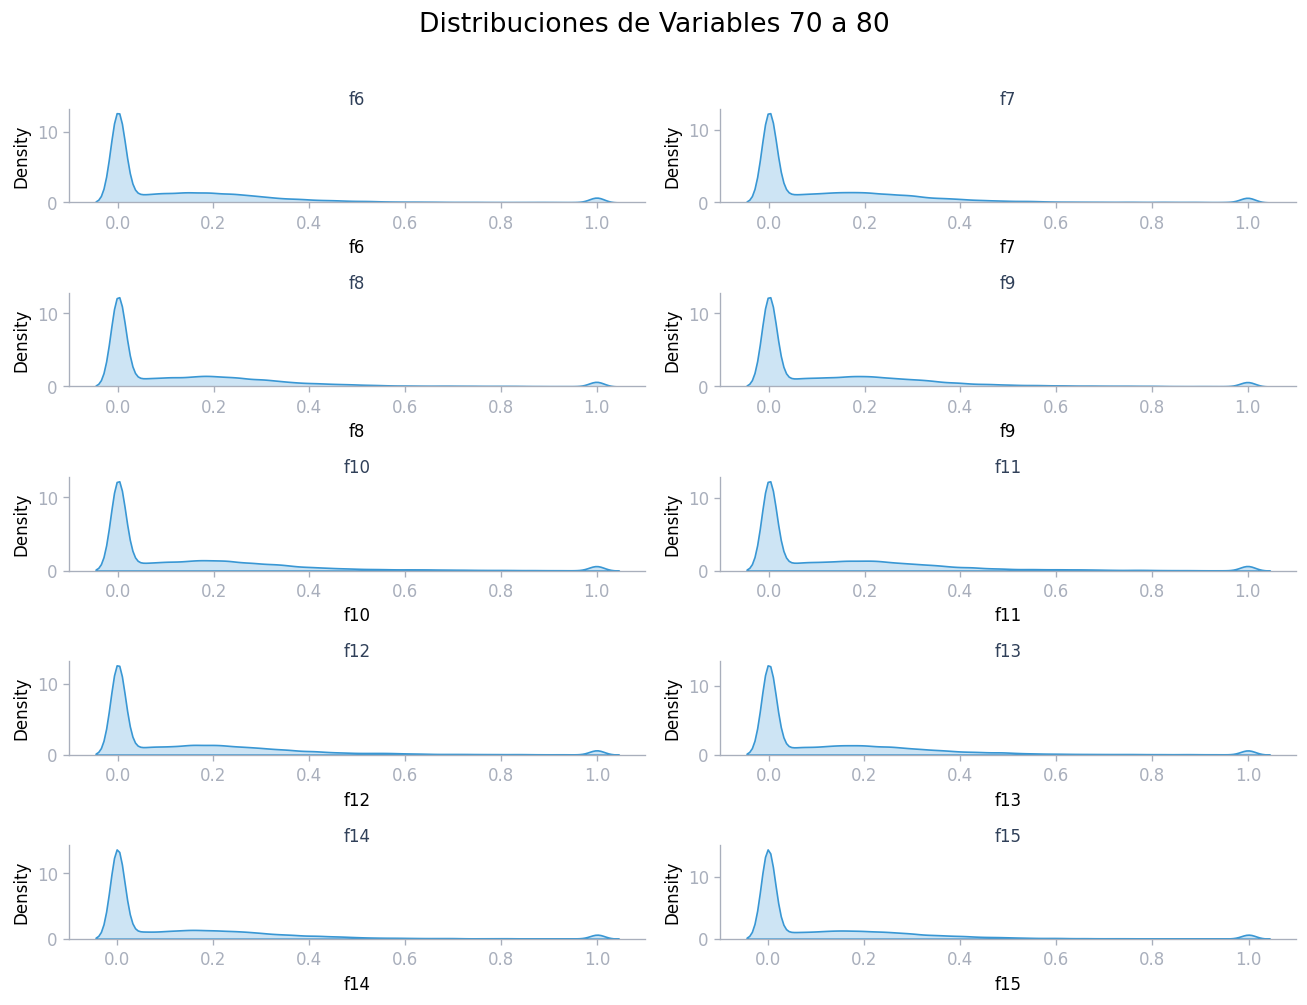

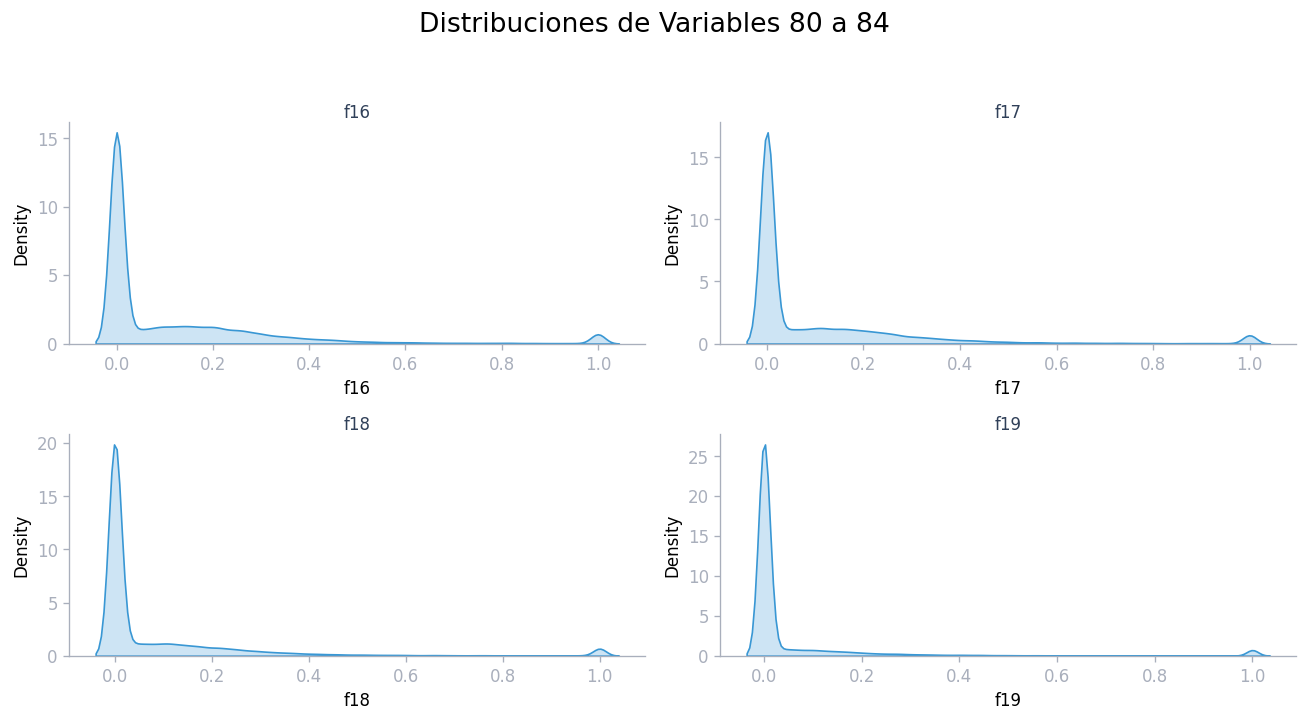

In [28]:
#Visualizando distribuciones
n_data2 = training[numeric_cols]
#Realizando gráficos
num_variables = n_data2.shape[1]
plots_per_page = 10
pages = (num_variables // plots_per_page) + (1 if num_variables % plots_per_page else 0)

for page in range(pages):
    start_index = page * plots_per_page
    end_index = min(start_index + plots_per_page, num_variables)
    plot_kde(n_data2, start_index, end_index, page + 1, plots_per_page,mClr)

In [32]:
#Guardando scalers
with mlflow.start_run(run_name = "MinMaxScaler"):
    for feature in scalers:
        mlflow.sklearn.log_model(scalers[feature], f"scaler_{feature}")
    mlflow.end_run()

2024/04/28 18:05:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


2024/04/28 18:05:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 18:05:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 18:05:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 18:05:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 18:05:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 18:05:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 18:05:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 18:05:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/28 18:05:36 WARNING mlflow.sklearn: Model was missing fu

In [29]:
#Checkeando for nans
print('Nans en training:',training.isna().sum().sum())
print('Nans en testing1:',testing1.isna().sum().sum())
print('Nans en testing2:',testing2.isna().sum().sum())

Nans en training: 0
Nans en testing1: 0
Nans en testing2: 0


In [30]:
#Eliminando columna inecesaria

training.drop(['ImgName','ImgName_neighbor'], axis=1, inplace=True)
testing1.drop(['ImgName','ImgName_neighbor'], axis=1, inplace=True)
testing2.drop(['ImgName','ImgName_neighbor'], axis=1, inplace=True)

In [31]:
training.sample(1000).to_csv('../../Data/DataMart/temp/training_sample.csv')

In [32]:
#Guardando datos
#Parquet
#training.to_parquet("../../Data/DataMart/Views/TrainingViews/training.parquet")
#testing1.to_parquet("../../Data/DataMart/Views/TrainingViews/testing1.parquet")
#testing2.to_parquet("../../Data/DataMart/Views/TrainingViews/testing2.parquet")
#CSV
#training.to_csv("../../Data/DataMart/Views/TrainingViews/training.csv")
#testing1.to_csv("../../Data/DataMart/Views/TrainingViews/testing1.csv")
#testing2.to_csv("../../Data/DataMart/Views/TrainingViews/testing2.csv")


In [33]:
#Reordenando conjunto de datos de entrenamiento
training_shuffled = training.sample(frac=1, random_state=1010)
#Guardando datos de entrenamiento sin orden
#training_shuffled.to_parquet("../../Data/DataMart/Views/TrainingViews/training_shuffled.parquet")
#training_shuffled.to_csv("../../Data/DataMart/Views/TrainingViews/training_shuffled.csv")

## Transformando MG

In [ ]:
#Leyendo datos
mg = pd.read_parquet("../../Data/DataMart/Views/DataViews/reduced_mg.parquet")
mg.head()

In [35]:
#Conservando solo status Normal
mg = mg[mg['status'] == 'Normal']

In [36]:
#Hash encoding
mg['serialNumber'] = mg['serialNumber'].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
mg['fixed_path'] = mg['fixed_path'].apply(hash_list)

In [ ]:
#Binary encoding
mg['CollectorNm'] = ordinal_gw.transform(np.array(mg['CollectorNm']).reshape(-1,1))
#Convirtiendo a binario
mg[col_names_1] = pd.DataFrame(ordinary_to_bits(mg['CollectorNm']), columns=col_names_1)
#Eliminando columna original
mg.drop(['CollectorNm'], axis=1, inplace=True)
mg.head()

In [38]:
#Tratando ronda
mg['round'] = mg['round'].str.extract('(\d+)').astype(str)

In [39]:
#One hot encoding nuevo
ohe_gw_status = OneHotEncoder()
#Ajustando
ohe_gw_status = ohe_gw_status.fit(np.array(mg['status']).reshape(-1,1))
#Transformando
gw_status = ohe_gw_status.transform(np.array(mg['status']).reshape(-1,1)).toarray()
#Columnas
gw_status_columns = [f'status_{i}' for i in range(gw_status.shape[1])]
#Asignando a df
mg[gw_status_columns] = pd.DataFrame(gw_status, columns=gw_status_columns)
#Eliminando columna original
mg.drop(['status'], axis=1, inplace=True)

In [40]:
#One hot encoding
gw_cluster = ohe_cluster.transform(np.array(mg['cluster']).reshape(-1,1)).toarray()
gw_type = ohe_type_neighbor.transform(np.array(mg['type']).reshape(-1,1)).toarray()
#Asignando a df
mg[cluster_columns] = pd.DataFrame(gw_cluster, columns=cluster_columns)
mg[type_neighbor_columns] = pd.DataFrame(gw_type, columns=type_neighbor_columns)
#Eliminando columnas originales
mg.drop(['cluster','type'], axis=1, inplace=True)

In [41]:
#MinMax Encoding nuevo
minmax_gw__ncd = MinMaxScaler()
minmax_gw_dslsc = MinMaxScaler()
#Fit
minmax_gw__ncd.fit(np.array(mg['NoCommunicatingDays']).reshape(-1,1))
minmax_gw_dslsc.fit(np.array(mg['DaysSinceLastStatusChanged']).reshape(-1,1))
#Transform
mg['NoCommunicatingDays'] = minmax_gw__ncd.transform(np.array(mg['NoCommunicatingDays']).reshape(-1,1))
mg['DaysSinceLastStatusChanged'] = minmax_gw_dslsc.transform(np.array(mg['DaysSinceLastStatusChanged']).reshape(-1,1))


In [ ]:
#MinMax Encoding
lat_scaler = scalers['latitude']
long_scaler = scalers['longitude']
rounds_scaler = scalers['round']
ncd_scaler = scalers['NoCommunicatingDays_neighbor']
num_of_neigh_scaler = scalers['numberOfNeighbors']
layer_scaler = scalers['layer']
dslsc_scaler = scalers['DaysSinceLastStatusChanged_neighbor']
#Transformando
mg['latitude'] = lat_scaler.transform(mg[['latitude']])
mg['longitude'] = long_scaler.transform(mg[['longitude']])
mg['round'] = rounds_scaler.transform(mg[['round']])
mg['numberOfNeighbors'] = num_of_neigh_scaler.transform(mg[['numberOfNeighbors']])
mg['layer'] = layer_scaler.transform(mg[['layer']])
#Visualizando datos
mg.head()

In [84]:
#Guardando modelos
with mlflow.start_run(run_name = "GW-MinMaxScaler"):
    mlflow.sklearn.log_model(minmax_gw__ncd, "minmax_gw__ncd")
    mlflow.sklearn.log_model(minmax_gw_dslsc, "minmax_gw_dslsc")
    mlflow.sklearn.log_model(lat_scaler, "lat_scaler")

2024/04/30 01:01:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/30 01:01:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/04/30 01:01:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [43]:
#Guardando datos
#Parquet
#mg.to_parquet("../../Data/DataMart/Views/TrainingViews/mg_prepared.parquet")
#CSV
#mg.to_csv("../../Data/DataMart/Views/TrainingViews/mg_prepared.csv")

## Tratando desbalance de clases - Undersampling

Con este enfoque se realizará un muestreo reducido de la clase mayoritaria (Communicating = 1), con el fin de conseguir un conjunto de datos con etiquetas balanceadas.

<AxesSubplot: title={'center': 'Conjunto de entrenamiento balanceado con undersampling'}>

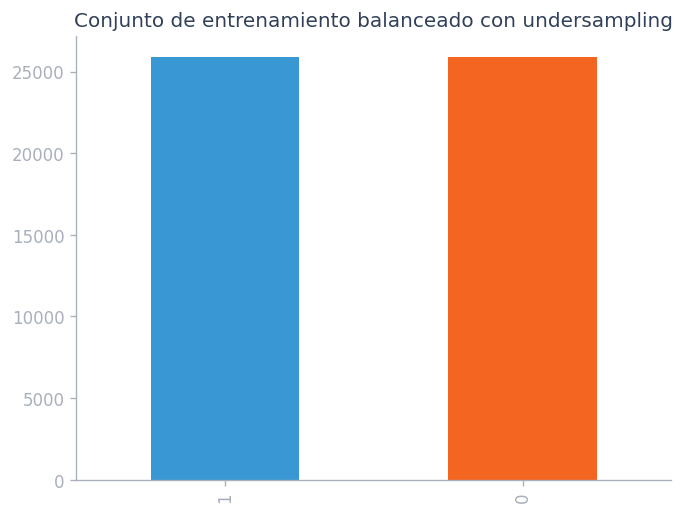

In [44]:
#Undersampling
len_nc = len(training[training['Communicating'] == 0])
nc_df = training[training['Communicating'] == 0]
c_df = training[training['Communicating'] == 1]
#Realizando undersampling
c_df = c_df.sample(len_nc, random_state=42)
#Concatenando
undersampled = pd.concat([c_df, nc_df])
#Reordenando
undersampled = undersampled.sample(frac=1, random_state=1010)
#Visualizando
undersampled['Communicating'].value_counts().plot(kind='bar', color=[mClr, sClr1], title = 'Conjunto de entrenamiento balanceado con undersampling')

In [45]:
#Guardando datos balanceados con undersampling
#undersampled.to_parquet("../../Data/DataMart/Views/TrainingViews/undersampled_shuffled.parquet")
#undersampled.to_csv("../../Data/DataMart/Views/TrainingViews/undersampled_shuffled.csv")


## Tratando desbalance de clases - Oversampling

Con este enfoque se realizará un muestreo aumentado de la clase minoritaria (Communicating = 0), con el fin de conseguir un conjunto de datos con etiquetas balanceadas.

In [46]:
#Aplicando oversampling
X = training_shuffled.drop('Communicating', axis=1)
y = training_shuffled['Communicating']
#Creando objeto
ros = RandomOverSampler(random_state=1010)
#Ajustando y aplicando
X_resampled, y_resampled = ros.fit_resample(X, y)

In [47]:
#Concatenando
training_oversampled = pd.concat([pd.DataFrame(X_resampled, columns = X.columns), pd.Series(y_resampled, name = "Communicating")], axis=1)
training_oversampled.head()

,serialNumber,latitude,longitude,round,fixed_path,FE-Comments,numberOfNeighbors,layer,path_length,h,...,cluster_gw_5,cluster_gw_6,cluster_gw_7,cluster_gw_8,cluster_gw_9,cluster_gw_10,antena_0,antena_1,antena_2,Communicating
0,ee129f5b32255e919ec41f06d41f2672,0.61046471,0.60215054,0.70000000,"[e3c3f8b8ca732c6419f14f15a79ca7f4, 97e01af5e9c...","[Layer imputed, numberON imputed]",0.31655386,0.07142857,0.25000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,1
1,104b28d0faecbd3271e9cd8f65a7eb47,0.57197876,0.39986735,0.40000000,"[7392fcb91425506993db84d4088f2662, 588f9343536...",[],0.26173858,0.00000000,0.08333333,0.52631579,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,1
2,125c5da623f65d5119feb772e83c0ccc,0.62312249,0.58552782,0.10000000,"[74c3493cf03d043cbbbc3de055ee6622, 55bd8ac03ce...",[],0.58375635,0.04761905,0.25000000,0.25263158,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,1
3,4100a706018ab67d46b6c59d61a15f2b,0.65893237,0.58486500,0.70000000,"[b77e657e2ba241ac242417ffc06362a1, 554a680dac5...",[],0.34898477,0.03174603,0.25000000,0.25263158,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,1
4,c1f45404676c4a6a9bdaf15ab2ef77e5,0.60619309,0.58513650,0.10000000,"[be2e2bfc59ddc53a0f5a8cdefd966679, 26db3e4a36c...",[],0.05076142,0.14285714,0.50000000,0.25263158,...,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,1


<AxesSubplot: title={'center': 'Conjunto de entrenamiento balanceado con oversampling'}>

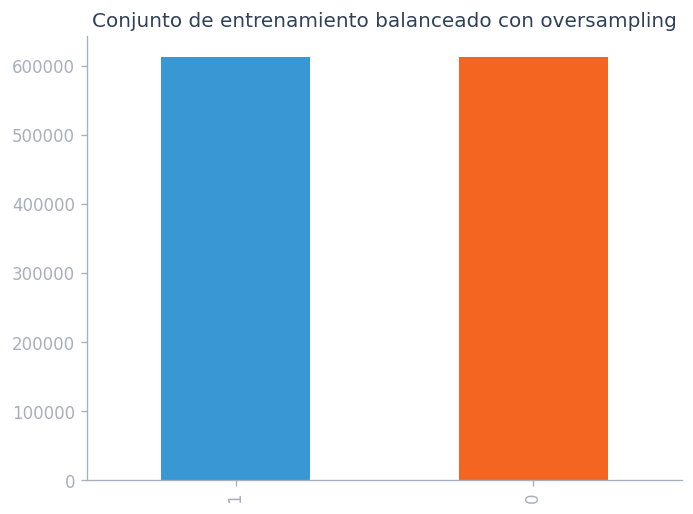

In [48]:
#Visualizando
training_oversampled['Communicating'].value_counts().plot(kind='bar', color=[mClr, sClr1], title = 'Conjunto de entrenamiento balanceado con oversampling')

In [49]:
#Guardando datos balanceados con oversampling
training_oversampled.to_parquet("../../Data/DataMart/Views/TrainingViews/oversampled_shuffled.parquet")
training_oversampled.to_csv("../../Data/DataMart/Views/TrainingViews/oversampled_shuffled.csv")